# The life of an athlete with type 1 diabetes: analysis

Descriptives for the 2019 training season of 14 TNN athletes

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from copy import copy

from plot import *
from calc import glucose_levels, mmoll_mgdl, mgdl_mmoll, timestamp_to_seconds
from config import DATA_PATH

In [2]:
SAVE_PATH = 'results/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [3]:
COL = 'Glucose Value (mg/dL)'
SECTIONS = ('wake', 'exercise', 'recovery', 'sleep')

### Read data

**Athlete characteristics**

In [4]:
info = pd.read_csv(DATA_PATH+'agg/info.csv')
info = info.reset_index()
info = info.rename(columns={'index':'RIDER'})
info

RIDER gender  nationality  age  diabetes_duration     weight      bf(%)  \
0       1      M  Switzerland   22                 11  60.500000   9.066667   
1       2      M        Italy   30                 14  71.633333   8.833333   
2       3      M      Ireland   26                  7  66.733333   6.566667   
3       4      M    Australia   19                  7  78.666667   9.433333   
4       5      M  Netherlands   25                  6  69.633333   7.700000   
5       6      M    Australia   20                  9  56.700000   4.950000   
6       7      M        Italy   22                  6  65.333333   8.066667   
7       8      M  New Zealand   20                 17  65.000000  11.900000   
8       9      M       France   23                 10  63.100000   8.533333   
9      10      M           UK   27                 17  75.466667   7.700000   
10     11      M  Netherlands   24                 15  70.700000   8.900000   
11     12      M        Spain   30                  8  64.000000   5.600000   
12     13      M      Hungary   34                  1  60.333333   4.866667   
13     14      M      Finland   27                 17  75.166667   9.333333   
14     15      M       France   25                 15  73.766667   7.200000   
15     16      M   Uzbekistan   22                 13  56.666667   9.466667   
16     17      M       France   22                  4        NaN        NaN   
17     18      M           US   26                  2        NaN        NaN   

    HbA1c         FTP        LTHR       HRmax     VO2max  height  
0     6.7  307.000000  176.333333  192.333333  68.888889   174.0  
1     6.6  326.000000  168.666667  181.666667  66.915285   178.0  
2     6.8  298.000000  171.000000  180.000000  66.666164   171.0  
3     7.8  356.000000  170.333333  187.333333  67.333333   178.0  
4     6.5  341.000000  179.666667  192.666667  72.857143   183.0  
5     6.4  298.500000  173.000000  184.500000  70.781588   169.0  
6     5.9  298.500000  171.500000  180.500000  72.203125   167.0  
7     7.7  292.000000  187.000000  204.000000  64.000000   165.0  
8     7.2  278.666667  182.333333  195.000000  67.522310   173.0  
9     7.3  377.333333  177.000000  194.333333  73.982571   185.0  
10    6.4  317.000000  175.000000  190.000000  65.000000   179.0  
11    6.0  347.000000  158.333333  178.666667  75.937500   178.0  
12    6.3  345.666667  173.000000  182.333333  76.666667   179.0  
13    7.1  348.000000  169.000000  189.500000  66.500000   187.0  
14    6.4  389.000000  185.000000  198.000000  66.000000   179.0  
15    6.6  283.333333  125.610000  200.333333  74.678571   170.0  
16    NaN         NaN         NaN         NaN        NaN   167.0  
17    NaN         NaN         NaN         NaN        NaN   180.0

**Professional**

In [5]:
pro = pd.read_csv(DATA_PATH+'info/pro.csv')
pro = pro.sort_values('RIDER')

Select only people for whom we have *ethics*

In [6]:
pro = pro[pro.ethics == 1]
pro = pro.drop('ethics', axis=1)

# anonymize file
pro = pro.drop('name', axis=1)
pro['RIDER'] = pro['RIDER'].astype(int)
pro = pro.reset_index(drop=True)

pro

RIDER 2014 2015 2016 2017 2018 2019 2020 2021
0       1    -    -    -  DEV  DEV  PRO  PRO  PRO
1       2  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
2       3  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
3       4    -    -    -  DEV  PRO  PRO  PRO  PRO
4       5    -  PRO  PRO  PRO  PRO  PRO  PRO  PRO
5       6    -    -    -  DEV  DEV  PRO  PRO  PRO
6       7    -    -  DEV  PRO  PRO  PRO  PRO  PRO
7       8    -    -    -  DEV  DEV  DEV  PRO  PRO
8       9    -    -    -  PRO  PRO  PRO  PRO  PRO
9      10    -    -  DEV  DEV  PRO  PRO  PRO  PRO
10     11    -  PRO  PRO  PRO    -  DEV  PRO  PRO
11     12  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
12     13    -    -    -    -    -  PRO  PRO  PRO
13     14  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
14     15  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
15     16    -    -    -  DEV  DEV  PRO  PRO  DEV
16     17    -    -    -    -    -    -    -    -
17     18    -    -    -  DEV  DEV  DEV  DEV  PRO

**Season dates**

In [7]:
season = pd.read_csv(DATA_PATH+'calendar/season_dates.csv', index_col=[0,1], header=[0,1])
season = season.reset_index().drop('level_1', axis=1)
season = season.rename(columns={'level_0':'RIDER'})
season

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER        2015                    2016                    2017  \
               start         end       start         end       start   
0      1         NaN         NaN         NaN         NaN  2016-12-06   
1      2  2014-11-17  2015-10-18  2015-11-24  2016-10-28  2016-11-15   
2      3  2014-11-06  2015-10-18  2015-11-06  2016-10-23  2016-12-06   
3      4         NaN         NaN         NaN         NaN  2016-11-15   
4      5  2014-11-14  2015-11-08  2015-11-27  2016-10-30  2016-11-12   
5      6         NaN         NaN         NaN         NaN  2016-12-12   
6      7         NaN         NaN  2015-10-07  2016-04-16  2016-11-07   
7      8         NaN         NaN         NaN         NaN  2016-12-14   
8      9         NaN         NaN         NaN         NaN  2016-12-06   
9     10         NaN         NaN  2015-11-06  2016-10-17  2016-11-04   
10    11  2014-11-02  2015-11-12  2015-12-01  2016-11-12  2016-12-07   
11    12  2014-11-15  2015-10-29  2015-11-24  2016-10-22  2016-11-07   
12    13         NaN         NaN         NaN         NaN         NaN   
13    14  2014-11-14  2015-10-25  2015-12-02  2016-10-30  2016-11-13   
14    15  2014-11-17  2015-10-18  2015-11-12  2016-10-23  2016-11-14   
15    16         NaN         NaN         NaN         NaN  2016-12-14   
16    17         NaN         NaN         NaN         NaN         NaN   
17    18         NaN         NaN         NaN         NaN  2016-12-13   

                      2018                    2019                    2020  \
           end       start         end       start         end       start   
0   2017-11-05  2017-11-13  2018-10-20  2018-11-05  2019-10-20  2019-11-04   
1   2017-09-11  2017-10-23  2018-10-02  2018-10-23  2019-10-16  2019-11-04   
2   2017-10-05  2017-11-13  2018-10-31  2018-11-19  2019-10-20  2019-11-13   
3   2017-09-30  2017-10-05  2018-11-01  2018-11-12  2019-10-16  2019-11-04   
4   2017-09-23  2017-10-03  2018-10-17  2018-11-12  2019-10-20  2019-11-11   
5   2017-10-14  2017-10-30  2018-10-25  2018-12-01  2019-10-01  2019-10-21   
6   2017-11-05  2017-11-28  2018-10-17  2018-11-29  2019-10-27  2019-12-02   
7   2017-11-05  2017-11-19  2018-12-12  2018-12-24  2019-10-16  2019-10-24   
8   2017-11-05  2017-11-20  2018-09-24  2018-11-05  2019-09-23  2019-10-14   
9   2017-11-12  2017-11-27  2018-11-10  2018-11-22  2019-10-28  2019-11-11   
10  2017-10-22         NaN         NaN  2018-10-15  2019-06-23  2019-10-23   
11  2017-10-31  2017-11-06  2018-11-11  2018-11-26  2019-11-05  2019-11-18   
12         NaN         NaN         NaN  2018-12-12  2019-10-20  2019-11-18   
13  2017-11-20  2017-12-21  2018-11-01  2018-11-12  2019-09-09  2019-10-21   
14  2017-11-01  2017-11-27  2018-10-21  2018-11-12  2019-10-20  2019-11-09   
15  2017-09-10  2017-11-21  2018-11-02  2018-11-19  2019-09-29  2019-11-14   
16         NaN         NaN         NaN         NaN         NaN         NaN   
17  2017-10-22  2017-11-20  2018-08-12  2018-10-22  2019-10-13  2019-11-09   

                      2021              
           end       start         end  
0   2020-09-23  2020-10-08  2021-10-30  
1   2020-10-11  2020-11-09  2021-10-04  
2   2020-10-16  2020-11-16  2021-10-03  
3   2020-10-28  2020-11-16  2021-08-14  
4   2020-10-31  2020-11-16  2021-08-31  
5   2020-07-17  2020-11-01  2021-09-03  
6   2020-10-12  2020-11-09  2021-09-30  
7   2020-09-27  2020-11-01  2021-10-03  
8   2020-10-12  2020-11-05  2021-10-01  
9   2020-10-11  2020-11-16  2021-10-17  
10  2020-10-02  2020-11-01  2021-09-17  
11  2020-10-08  2020-11-01  2021-09-03  
12  2020-10-11  2020-11-16  2021-09-05  
13  2020-10-12  2020-11-02  2021-09-20  
14  2020-10-15  2020-11-07  2021-10-29  
15  2020-10-31  2020-11-23  2021-09-30  
16         NaN         NaN         NaN  
17  2020-10-18  2020-11-11  2021-10-05

**TrainingPeaks (aggregated)**

In [8]:
tp_agg = pd.read_csv(DATA_PATH+'agg/trainingpeaks_day.csv', index_col=[0,1], header=[0,1])
tp_agg = tp_agg.reset_index()
tp_agg['date'] = pd.to_datetime(tp_agg['date'])
tp_agg

RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                           CALENDAR                                   \
       local_timestamp_max     race travel race_3d_mean race_7d_mean   
0      2016-11-22 15:15:40    False   True          0.0          0.0   
1      2016-11-23 16:35:14    False  False          0.0          0.0   
2      2016-11-24 16:56:38    False  False          0.0          0.0   
3      2016-11-26 12:12:52    False  False          0.0          0.0   
4      2016-12-06 16:11:38    False  False          0.0          0.0   
...                    ...      ...    ...          ...          ...   
30207  2021-11-18 16:19:15    False  False          0.0          0.0   
30208  2021-11-25 12:54:14    False  False          0.0          0.0   
30209  2021-11-26 12:39:08    False  False          0.0          0.0   
30210  2021-11-27 14:36:43    False  False          0.0          0.0   
30211  2021-11-28 14:21:57    False  False          0.0          0.0   

                     ...             LOC                                  \
      travel_3d_any  ... distance_up_std distance_up_min distance_up_max   
0              True  ...    17801.944942            3.02        60211.87   
1              True  ...    19148.044265            0.00        66126.45   
2              True  ...     9053.264194            3.43        34317.18   
3             False  ...    18440.805479            1.10        65340.95   
4             False  ...    19543.224138            0.00        64799.24   
...             ...  ...             ...             ...             ...   
30207         False  ...     9128.714210            0.00        29709.74   
30208         False  ...    21912.188008            0.00        80574.10   
30209         False  ...    19439.456819            0.00        62597.98   
30210         False  ...    38862.374584            0.00       130010.95   
30211         False  ...    33132.807679            3.57       109086.89   

                                                                            \
      distance_up_sum distance_up_energy distance_up_peaks distance_up_rms   
0        1.615842e+08       6.454802e+12               0.0    29442.856294   
1        2.109715e+08       9.441041e+12               0.0    35932.864834   
2        6.765391e+07       1.379010e+12               0.0    14812.591736   
3        1.908990e+08       8.218843e+12               0.0    33225.612828   
4        2.761122e+08       1.133536e+13               1.0    31782.096599   
...               ...                ...               ...             ...   
30207    5.001524e+07       1.099600e+12               0.0    15187.800246   
30208    2.989028e+08       1.488329e+13               0.0    36931.529437   
30209    1.875908e+08       8.146286e+12               0.0    30535.051494   
30210    7.310406e+08       6.144018e+13               0.0    58066.844495   
30211    5.640191e+08       4.316849e+13               0.0    54471.190338   

                                                           
      distance_up_iqr acceleration_iqr elevation_gain_iqr  
0                 NaN              NaN                NaN  
1                 NaN              NaN                NaN  
2    

**Dexcom (aggregated)**

In [9]:
dc_agg = pd.read_csv(DATA_PATH+'agg/dexcom_day.csv')
dc_agg['date'] = pd.to_datetime(dc_agg['date'])

dc_agg = dc_agg.dropna(subset=['glucose_mean_1d'])
dc_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (55,56,73,74,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RIDER       date  time_in_hypo_exercise  time_in_hypoL2_exercise  \
1351       1 2017-09-12                    0.0                      0.0   
1352       1 2017-09-13                    0.0                      0.0   
1353       1 2017-09-14                    0.0                      0.0   
1354       1 2017-09-15                    7.0                      0.0   
1355       1 2017-09-16                    0.0                      0.0   
...      ...        ...                    ...                      ...   
52563     18 2021-11-11                    NaN                      NaN   
52564     18 2021-11-12                    NaN                      NaN   
52565     18 2021-11-13                    NaN                      NaN   
52566     18 2021-11-14                    NaN                      NaN   
52567     18 2021-11-15                    NaN                      NaN   

       time_in_hypoL1_exercise  time_in_target_exercise  \
1351                       0.0                      0.0   
1352                       0.0                     66.0   
1353                       0.0                     19.0   
1354                       7.0                    107.0   
1355                       0.0                     29.0   
...                        ...                      ...   
52563                      NaN                      NaN   
52564                      NaN                      NaN   
52565                      NaN                      NaN   
52566                      NaN                      NaN   
52567                      NaN                      NaN   

       time_in_hyper_exercise  time_in_hyperL1_exercise  \
1351                      0.0                       0.0   
1352                      3.0                       3.0   
1353                      8.0                       8.0   
1354                     17.0                      17.0   
1355                      9.0                       9.0   
...                       ...                       ...   
52563                     NaN                       NaN   
52564                     NaN                       NaN   
52565                     NaN                       NaN   
52566                     NaN                       NaN   
52567                     NaN                       NaN   

       time_in_hyperL2_exercise  glucose_mean_exercise  ...  glucose_std_14d  \
1351                        0.0                    NaN  ...        40.969276   
1352                        0.0             122.130435  ...        46.700315   
1353                        0.0             173.370370  ...        48.064211   
1354                        0.0             118.305344  ...        48.532327   
1355                        0.0             164.473684  ...        46.039394   
...                         ...                    ...  ...              ...   
52563                       NaN                    NaN  ...        72.477125   
52564                       NaN                    NaN  ...        72.514296   
52565                       NaN                    NaN  ...        73.671939   
52566                       NaN                    NaN  ...        73.043166   
52567                       NaN                    NaN  ...        72.599145   

       glucose_cv_14d  glucose_rate_14d  completeness_14d  count_14d  \
1351         0.255206        160.534091          0.021825         88   
1352         0.283073        164.976064          0.093254        376   
1353         0.322406        149.079882          0.167659        676   
1354         0.357283        135.837137          0.239087        964   
1355         0.339021        135.800844          0.293899       1185   
...               ...               ...               ...        ...   
52563        0.438070        165.446548          0.930308       3751   
52564        0.433276        167.362961          0.934772       3769   
52565        0.440168        167.372321          0.937252       3779   
52566  

In [10]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 18 ; D = 30212
Dexcom: N = 18 ; D = 11786


### Select data

Select riders that were pro in 2019

In [11]:
ATHLETES = pro.loc[pro['2019'] == 'PRO', 'RIDER'].to_list()

In [12]:
info = info[info.RIDER.isin(ATHLETES)].set_index('RIDER')
season = season[season.RIDER.isin(ATHLETES)].set_index('RIDER')

In [13]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)]))
print("Dexcom: N =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)]))

Data available: 
TrainingPeaks: N = 14 ; D = 25116
Dexcom: N = 14 ; D = 9229


Select beginning and end of the training season in 2019

In [14]:
season = season['2019']

season['start'] = pd.to_datetime(season['start'])
season['end'] = pd.to_datetime(season['end'])

season_list = season.apply(lambda x: pd.date_range(x[0], x[1], freq='1D'), axis=1)\
    .apply(pd.Series).stack().reset_index().drop('level_1', axis=1).rename(columns={0:'date'})

tp_agg = pd.merge(tp_agg, season_list, how='inner', on=['RIDER', 'date'])

dc_agg = pd.merge(dc_agg, season_list, how='inner', on=['RIDER', 'date'])

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [15]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 14 ; D = 3828
Dexcom: N = 14 ; D = 3060


Redefine day to be between 06am - 06am

In [16]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

# move all data from sleep to the next day, so that sleep always contains next day sleep
date_range = pd.date_range(start=season['start'].min(), end=season['end'].max())
dc_agg = dc_agg.reindex(pd.MultiIndex.from_product([dc_agg.index.get_level_values(0).unique(), date_range], names=['RIDER', 'date']))

cols_sleep = dc_agg.columns[dc_agg.columns.str.endswith('sleep')]
dc_agg[cols_sleep] = dc_agg.groupby('RIDER')[cols_sleep].apply(lambda x: x.shift(-1))

dc_agg = dc_agg.dropna(how='all')
dc_agg = dc_agg.reset_index()

In [17]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 14 ; D = 3828
Dexcom: N = 14 ; D = 3232


Select data with glucose completeness >= 70% and remove nans from dexcom data

In [18]:
dc_agg = dc_agg[dc_agg['completeness_1d'] >= 0.7]

In [19]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 14 ; D = 3828
Dexcom: N = 14 ; D = 2120


Select participants with 14 or more days of data

In [20]:
mask = dc_agg.groupby('RIDER')['date'].nunique() >= 14
ATHLETES = mask[mask].index
tp_agg = tp_agg[tp_agg.RIDER.isin(ATHLETES)]
dc_agg = dc_agg[dc_agg.RIDER.isin(ATHLETES)]

In [21]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 12 ; D = 3370
Dexcom: N = 12 ; D = 2102


### Prepare features

Glucose data preparation

In [22]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

col_mask = dc_agg.columns.str.startswith('hypo') |  dc_agg.columns.str.startswith('hyper')
dc_agg.loc[:, col_mask] = dc_agg.loc[:, col_mask].astype('category')

"""
# calculate percentage in glucose levels
for sec in ('wake', 'sleep', 'exercise', 'recovery', '1h', '3h', '6h', '12h', '18h', '1d', '3d', '7d', '14d'):
    cols_zones = [f'time_in_{n}_{sec}' for n in ('hypo', 'hypoL2', 'hypoL1', 'target', 'hyper', 'hyperL1', 'hyperL2')]
    dc_agg[['perc'+col.lstrip('time') for col in cols_zones]] = dc_agg[cols_zones].apply(lambda col: col.divide(dc_agg['count_'+sec]))
    dc_agg = dc_agg.drop(cols_zones, axis=1)"""

# drop samples if glucose during sleep, exercise and recovery are zero
dc_agg = dc_agg.dropna(subset=['glucose_mean_exercise', 'glucose_mean_recovery', 'glucose_mean_sleep'], how='all')
dc_agg = dc_agg.reset_index()

In [23]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.index.get_level_values(0).unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 12 ; D = 3370
Dexcom: N = 2096 ; D = 2096


In [24]:
# TODO !!!!!!!!!!!
# still dropna of target

TrainingPeaks data preparation

In [25]:
# TODO: count is not exactly duration (because we only count when there's a measurement)

# prepare time features
tp_agg[('TIME', 'time_start')] = timestamp_to_seconds(tp_agg[('TIME', 'local_timestamp_min')])
tp_agg[('TIME', 'time_end')] = timestamp_to_seconds(tp_agg[('TIME', 'local_timestamp_max')])
tp_agg = tp_agg.drop([('TIME', 'local_timestamp_min'),
                      ('TIME', 'local_timestamp_max')], axis=1)
tp_agg = tp_agg.rename(columns={'timestamp_count':'duration'})

# get day in season
season_list['day_in_season'] = season_list.groupby('RIDER')['date'].transform(lambda x: x - x.min()).dt.days
season_list.columns = pd.MultiIndex.from_tuples([('RIDER', ''), ('date', ''), ('TIME', 'day_in_season')])
tp_agg = pd.merge(tp_agg, season_list, how='left', on=['RIDER', 'date'])

"""
# calculate percentage in zones
cols_zones = [('POWER', 'time_in_power_zone%s'%n) for n in range(1,7)] + [('HR', 'time_in_hr_zone%s'%n) for n in range(1,6)]
tp_agg[[(mod, 'perc'+c.lstrip('time')) for (mod, c) in cols_zones]] = tp_agg[cols_zones].apply(lambda col: col.divide(tp_agg[('TIME', 'duration')]))
tp_agg = tp_agg.drop(cols_zones, axis=1)"""

cols_cat = [('CALENDAR', 'race'), ('CALENDAR', 'travel'),
            ('CALENDAR', 'travel_3d_any'), ('CALENDAR', 'travel_7d_any')]
tp_agg[cols_cat] = tp_agg[cols_cat].astype('category')

# replace np.inf
tp_agg = tp_agg.replace({np.inf:np.nan})

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Replace extreme values

In [26]:
from scipy.stats import zscore

def clip_extremes(df, z_max=4, **kwargs):
    """
    Clip extreme values: when values exceed z_max, replace with mu+-z_max*std
    """
    z = zscore(df, **kwargs)
    mu = df.mean() 
    sigma = df.std()
    df = df.mask(z > z_max, mu + z_max*sigma)
    df = df.mask(z < -z_max, mu - z_max*sigma)
    return df
    
# note: we do not winsorize as that is based on percentiles, rather clip based on std
cols_extreme = tp_agg.set_index(['RIDER', 'date']).columns.drop(cols_cat).drop([('CALENDAR', 'race_3d_mean'), 
                                                                                ('CALENDAR', 'race_7d_mean')])
z = np.abs(zscore(tp_agg[cols_extreme], nan_policy='omit'))
print("Percentage of extreme values in data: {:.2f}%".format(
    (z > 4).sum().sum() / tp_agg[cols_extreme].count().sum() * 100))
for col in cols_extreme:
    tp_agg[col] = clip_extremes(tp_agg[col], nan_policy='omit')
# TODO: aggregate on raw data (clip peaks??)

Percentage of extreme values in data: 0.46%


Select only features that we think are relevant for this analysis

In [22]:
cols_X = [# exercise intensity output
          'POWER_normalised_power',
          'POWER_intensity_factor',
          'POWER_training_stress_score',
          'POWER_variability_index',
          'POWER_efficiency_factor',
          'POWER_time_in_power_zone1',
          'POWER_time_in_power_zone2',
          'POWER_time_in_power_zone3',
          'POWER_time_in_power_zone4',
          'POWER_time_in_power_zone5',
          'POWER_time_in_power_zone6',
          
          # exercise intensity input
          'HR_heart_rate_mean',
          'HR_time_in_hr_zone1',
          'HR_time_in_hr_zone2',
          'HR_time_in_hr_zone3',
          'HR_time_in_hr_zone4',
          'HR_time_in_hr_zone5',

          # competitive aspect
          'CALENDAR_race',
    
          # physical fitness
          'POWER_chronic_training_load', # fitness
          'POWER_acute_training_load', # fatigue
          'POWER_training_stress_balance', # form
          'TIME_day_in_season',
    
          # external/environmental/circumstantial effects
          'CALENDAR_travel_3d_any', # TODO: is this rather physical fitness
          'CALENDAR_country_carbs', # TODO: is this rather physical fitness
          'LOC_temperature_mean',
          'LOC_altitude_mean',

          # UNKNOWN CATEGORIES
          'TIME_duration',
          'TIME_time_start']

In [23]:
tp_agg = tp_agg.set_index(['RIDER', 'date'])
tp_agg.columns = ['_'.join(col) for col in tp_agg.columns]
X = tp_agg[cols_X]

In [24]:
X

TIME_duration  HR_heart_rate_mean  POWER_intensity_factor  \
RIDER date                                                                    
1     2018-11-05         7767.0          166.758017                0.710002   
      2018-11-06         8065.0          156.035338                0.592906   
      2018-11-07        11349.0          160.294387                0.710153   
      2018-11-08         7649.0          147.380180                0.681450   
      2018-11-09        11297.0          145.930854                0.709012   
...                         ...                 ...                     ...   
16    2019-09-22         7113.0          149.778996                0.891305   
      2019-09-24         6530.0          124.869832                0.493494   
      2019-09-27         7462.0                 NaN                0.527048   
      2019-09-28         3157.0          144.937758                0.256291   
      2019-09-29         3188.0          132.460163                0.277357   

                  POWER_normalised_power  POWER_power_sum  POWER_power_mean  \
RIDER date                                                                    
1     2018-11-05              217.970732        1470385.0        209.247901   
      2018-11-06              182.022246        1321130.0        175.285923   
      2018-11-07              218.016912        2028931.0        209.168144   
      2018-11-08              209.205185        1413309.0        203.999567   
      2018-11-09              217.666812        2122521.0        211.091099   
...                                  ...              ...               ...   
16    2019-09-22              252.536431        1196143.0        189.833836   
      2019-09-24              139.823166         659534.0        120.661178   
      2019-09-27              149.330328         796348.0        126.807006   
      2019-09-28               72.615705          83232.0         68.167076   
      2019-09-29               78.584360          89245.0         74.185370   

                  HR_perc_in_hr_zone3  HR_perc_in_hr_zone4  \
RIDER date                                                   
1     2018-11-05             0.382645             0.458761   
      2018-11-06             0.721017             0.099690   
      2018-11-07             0.558287             0.288572   
      2018-11-08             0.532226             0.000000   
      2018-11-09             0.530583             0.000000   
...                               ...                  ...   
16    2019-09-22             0.051736             0.101785   
      2019-09-24             0.225881             0.458761   
      2019-09-27             0.000000             0.000000   
      2019-09-28             0.314539             0.097878   
      2019-09-29             0.419699             0.051757   

                  HR_perc_in_hr_zone5  POWER_training_stress_score  ...  \
RIDER date                                                          ...   
1     2018-11-05             0.000000                   108.760305  ...   
      2018-11-06             0.001736                    78.754261  ...   
      2018-11-07             0.000000                   158.985937  ...   
      2018-11-08             0.000000                    98.666630  ...   
      2018-11-09             0.000000                   157.749616  ...   
...                               ...                          ...  ...   
16    2019-09-22             0.577534                   156.965078  ...   
      2019-09-24             0.228943                    44.174699  ...   
      2019-09-27             0.000000                    57.577585  ...   
      2019-09-28             0.475451                     5.760204  ...   
      2019-09-29             0.358218                     6.812283  ...   

                  POWER_form  POWER_variability_index  \
RIDER date                                              
1     2018-11-05   33.528338                 1.041687   
      20

Plot distributions

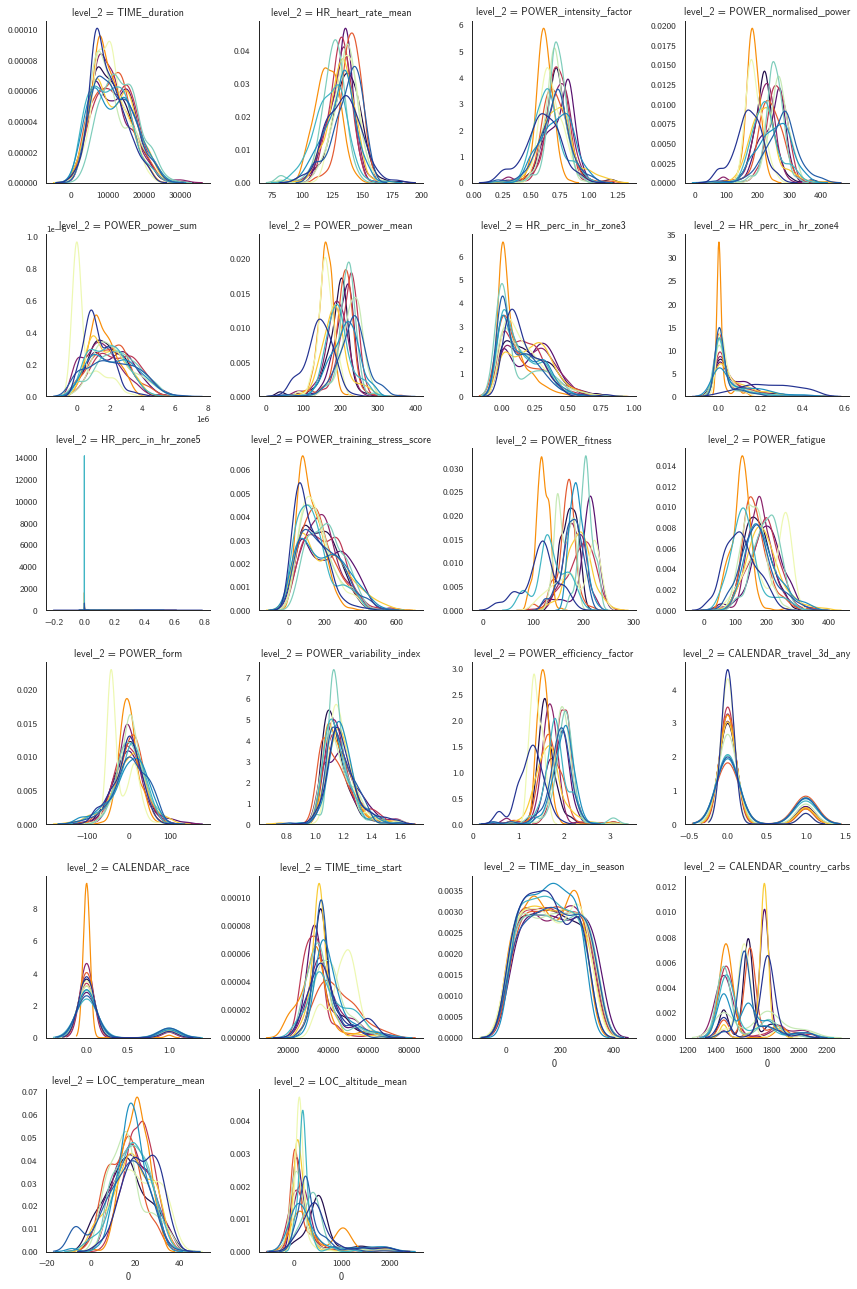

In [25]:
g = sns.FacetGrid(X.astype(float).stack().reset_index(), hue='RIDER', palette=palette_ath, 
                  col="level_2", col_wrap=4, sharex=False, sharey=False)
g.map(sns.kdeplot, 0)

# TODO: check individual peaks and perhaps clean them out?

Plot correlations

In [26]:
corr = X.corr()

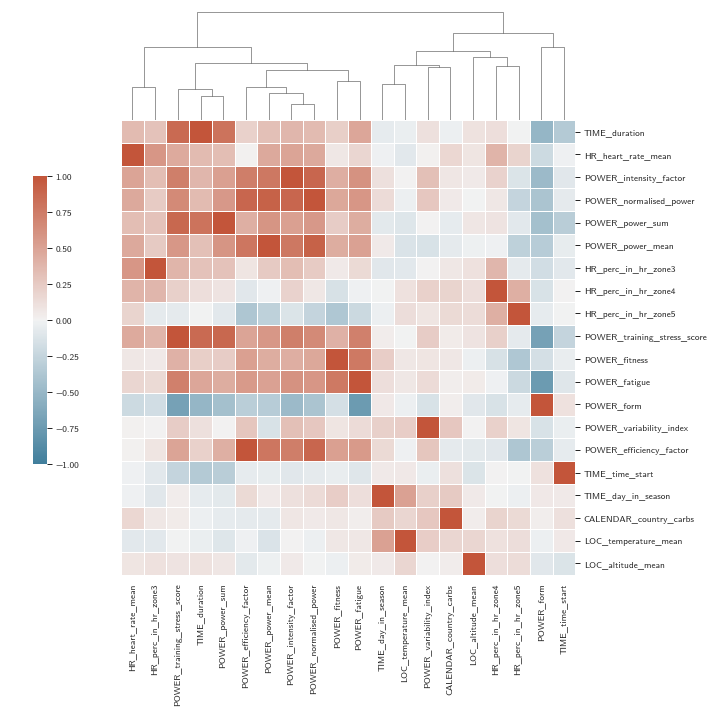

In [27]:
sns.clustermap(corr, vmin=-1, vmax=1, center=0, row_cluster=False, cbar_pos=(0.05, .35, .02, .4),
    linewidths=.5, cmap=sns.diverging_palette(230,20,as_cmap=True))
plt.xlabel('') ; plt.ylabel('') ; plt.show()

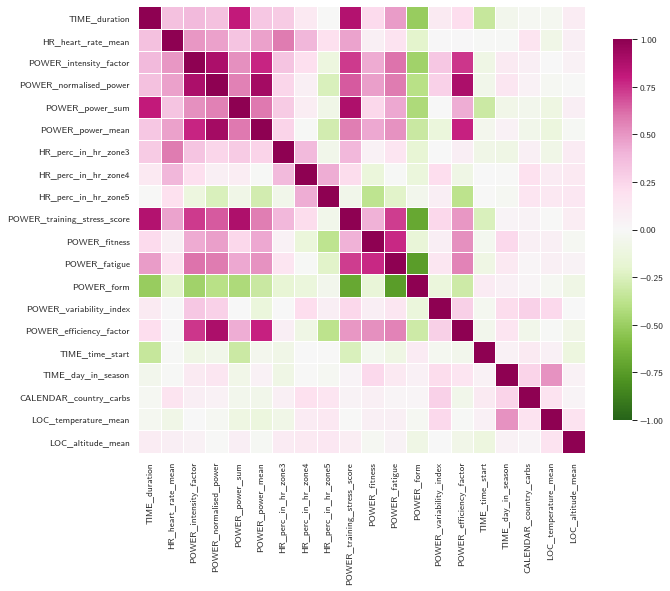

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='PiYG_r',
            linewidths=.5, cbar_kws=dict(shrink=0.7), square=True)
plt.xlabel('') ; plt.ylabel('') ; plt.show()

In [29]:
cols_y = ['hypo_'+sec for sec in SECTIONS] + ['hyper_'+sec for sec in SECTIONS]
y = dc_agg[cols_y]

cols_y = ['GLUCOSE_'+col for col in y.columns]

y.columns = cols_y
y = y.astype(float)

Preprocessing pipeline (separate for two data sources)

In [30]:
# TODO: scale per individual athlete
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

def preprocessing(df, drop_vif=False):    
    # normalize
    cols_scale = df.columns[(df.dtypes == float) | (df.dtypes == int)]
    scaler = StandardScaler()
    df[cols_scale] = scaler.fit_transform(df[cols_scale])

    # remove features with more than 30% nan
    plt.hist(df.notna().sum() / df.shape[0]) ; plt.axvline(0.3, color='red') ; plt.xlim((0,1)) ; plt.show()
    print("DROP: features with more than 30% nan: ", df.columns[df.notna().sum() / df.shape[0] < 0.3])
    df = df[df.columns[df.notna().sum() / df.shape[0] >= 0.3]]

    # remove features with low variance
    selector = VarianceThreshold()
    selector.fit(df)
    print("DROP: features with zero variance: ", df.columns[~selector.get_support()])
    df = df.loc[:, selector.get_support()]
    
    # impute variables
    imputer = SimpleImputer()
    df[:] = imputer.fit_transform(df)
    
    if drop_vif:
        # remove multicollinearity with variance inflation factor
        df['const'] = 1
        vif = pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=df.columns)
        print("DROP: features with high VIF: ", vif[vif > 10])
        df = df[vif.index[vif <= 10]]
        if 'const' in df:
            df = df.drop('const', axis=1)
    return df

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


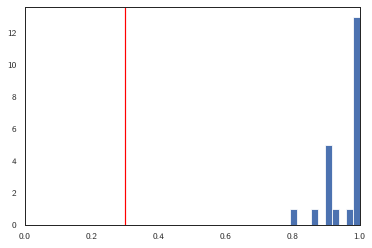

DROP: features with more than 30% nan:  Index([], dtype='object')
DROP: features with zero variance:  Index([], dtype='object')


In [31]:
X = preprocessing(X)
X = X.reset_index()

*Note: VIF is infinite if there is 100% correlation*

Merge cycling + glucose data

In [32]:
y = y.reset_index()

data = pd.merge(X, y, on=['RIDER', 'date'], how='inner') # TODO: think about how
data = data.drop('date', axis=1)
data = data.set_index('RIDER')

In [33]:
""" # ONLY DO THIS IF Y IS PERC_IN_...
g = sns.FacetGrid(y.stack().reset_index(), col="level_1", col_wrap=2, height=3, aspect=2, xlim=(0,.1),
                  hue='RIDER', palette=palette_ath)
g.map(sns.kdeplot, 0, common_norm=True)
"""

' # ONLY DO THIS IF Y IS PERC_IN_...\ng = sns.FacetGrid(y.stack().reset_index(), col="level_1", col_wrap=2, height=3, aspect=2, xlim=(0,.1),\n                  hue=\'RIDER\', palette=palette_ath)\ng.map(sns.kdeplot, 0, common_norm=True)\n'

In [34]:
print("Data available: N =", len(data.index.get_level_values(0).unique()), "; D =", len(data))

Data available: N = 14 ; D = 1611


In [35]:
data

TIME_duration  HR_heart_rate_mean  POWER_intensity_factor  \
RIDER                                                              
1          -0.703021            2.796759                0.061562   
1          -0.645021            1.928133               -0.881411   
1          -0.005848            2.273151                0.062773   
1          -0.725988            1.226992               -0.168369   
1          -0.015969            1.109585                0.053590   
...              ...                 ...                     ...   
16         -0.914586           -1.500632               -0.840375   
16          1.823113            1.705637                0.769894   
16          0.523747            0.244530                0.498398   
16          0.564036            0.665501                0.218984   
16         -0.441824           -2.497433               -1.164035   

       POWER_normalised_power  POWER_power_sum  POWER_power_mean  \
RIDER                                                              
1                   -0.323981        -0.371639          0.244452   
1                   -1.066852        -0.491903         -0.598996   
1                   -0.323027         0.078417          0.242471   
1                   -0.505120        -0.417628          0.114109   
1                   -0.330261         0.153828          0.290228   
...                       ...              ...               ...   
16                  -1.326988        -0.877161         -1.496879   
16                  -0.156218        -0.688227         -0.371737   
16                  -0.353613         0.307545         -0.545822   
16                  -0.556764         0.406923         -0.468734   
16                  -1.562309        -0.858788         -2.175237   

       HR_perc_in_hr_zone3  HR_perc_in_hr_zone4  HR_perc_in_hr_zone5  \
RIDER                                                                  
1                 1.409364             4.127114            -0.249960   
1                 3.575643             0.404033            -0.234454   
1                 2.533838             2.362483            -0.249960   
1                 2.366996            -0.629619            -0.249960   
1                 2.356477            -0.629619            -0.249960   
...                    ...                  ...                  ...   
16                0.994317             3.047530             0.247462   
16               -0.682999             0.911736             4.908687   
16               -0.047962             1.806684             4.745598   
16               -0.359651             1.143881             4.908687   
16                1.004880             0.393701            -0.104832   

       POWER_training_stress_score  ...  LOC_temperature_mean  \
RIDER                               ...                         
1                        -0.605166  ...             -1.412435   
1                        -0.891022  ...             -1.351121   
1                        -0.126686  ...             -1.187983   
1                        -0.701325  ...             -1.326070   
1                        -0.138464  ...             -1.173284   
...                            ...  ...                   ...   
16                       -1.009137  ...             -0.655589   
16                        1.854415  ...             -1.388698   
16                        0.533411  ...             -0.408529   
16                        0.369586  ...             -0.860199   
16                       -0.891250  ...             -0.198871   

       LOC_altitude_mean  GLUCOSE_hypo_wake  GLUCOSE_hypo_exercise  \
RIDER                                                                
1               0.273887                1.0                    1.0   
1               0.208766                1.0                    0.0   
1               0.637443                1.0                    1.0   
1               0.517917                1.0                    1.0   
1               0.559446          

# Statistical analysis

**IDEAS**
- Zero-inflated model (split into log-res and normal res)
- Only add random effects for variables that you are interested in (or that make sense)

**STEPS independent variables**:
1. Decide whether variable is included or not
2. For each variable, check:
    * *distribution*
    * *outliers*
3. For each variable, decide if should be *discretized*.
4. For each variable, create:
    * *non-linearities*
    * *interactions*
5. For each variable, potentially add: *random effects*

**STEPS dependent variables**:
1. Decide on *link function*, e.g. binomial (logit) or zero-inflated.
2. Pool dependent variables.

**STEPS robustness**:
1. Test on other years
2. Leave one-athlete-out cross-validation

In [36]:
cols_select = {'TIME_duration'           : 'Duration', # length of cycling
            'POWER_intensity_factor'     : 'Intensity factor', # normalized power / FTP (intensity of exercise, normalized by athlete's FTP)
            'HR_heart_rate_mean'         : 'Heart rate', # mean heart rate during session
            'CALENDAR_race'              : 'Competitive aspect', # race or not
            'POWER_training_stress_score': 'Training stress score', # duration * intensity factor
            'POWER_variability_index'    : 'Variability index', # normalized power / mean power
            'POWER_efficiency_factor'    : 'Efficiency factor', # normalized power / mean heart rate
            'TIME_time_start'            : 'Starting time', # first timestamp of exercise
            'TIME_day_in_season'         : 'Day in season', # day in the season
            'CALENDAR_travel_3d_any'     : 'Travel', # any travel in the last 3 days
            'LOC_temperature_mean'       : 'Temperature', # mean temperature during execise
            'LOC_altitude_mean'          : 'Altitude'} # mean altitude during exercise

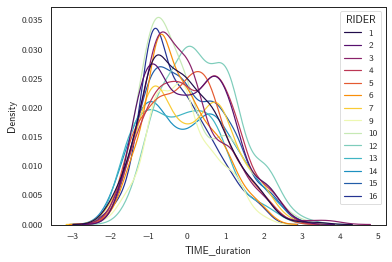

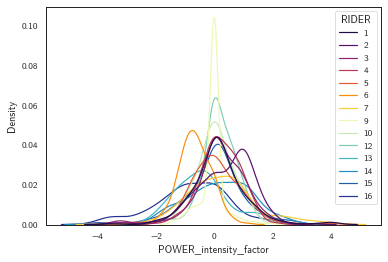

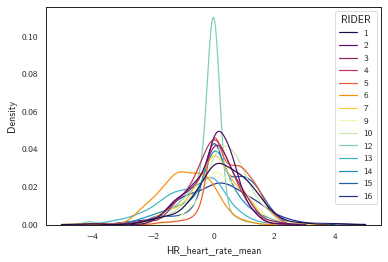

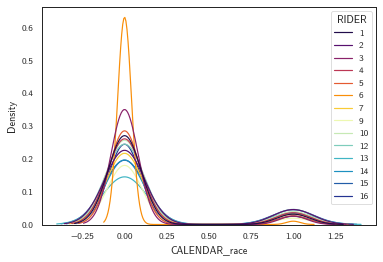

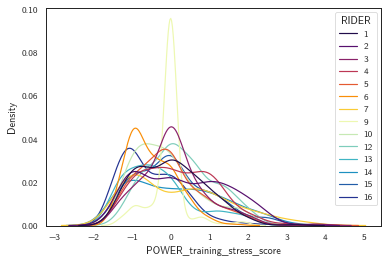

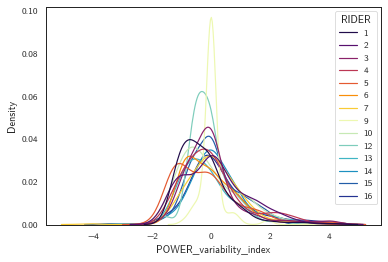

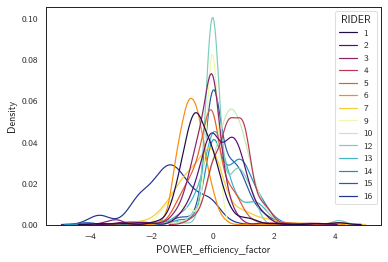

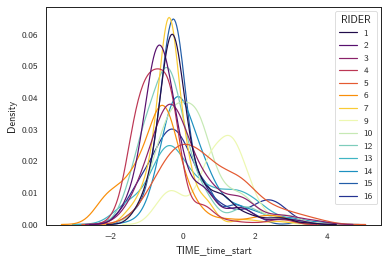

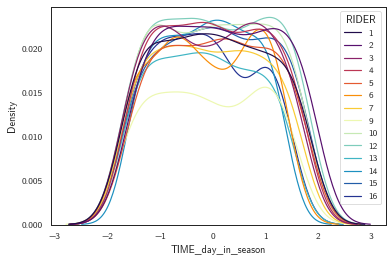

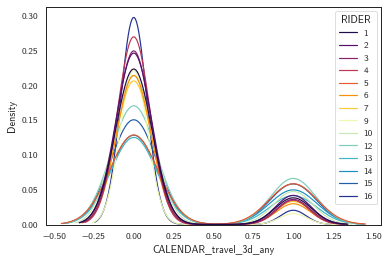

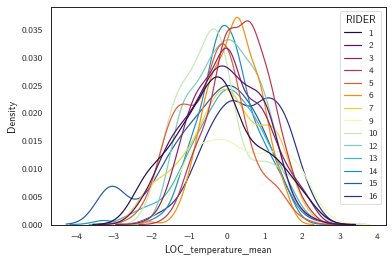

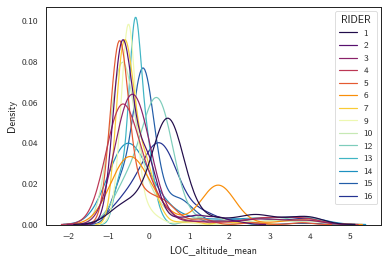

In [37]:
for col in cols_select:
    sns.kdeplot(data=X, x=col, hue='RIDER', palette=palette_ath)
    plt.show()

In [38]:
corr = data[cols_select.keys()].corr()

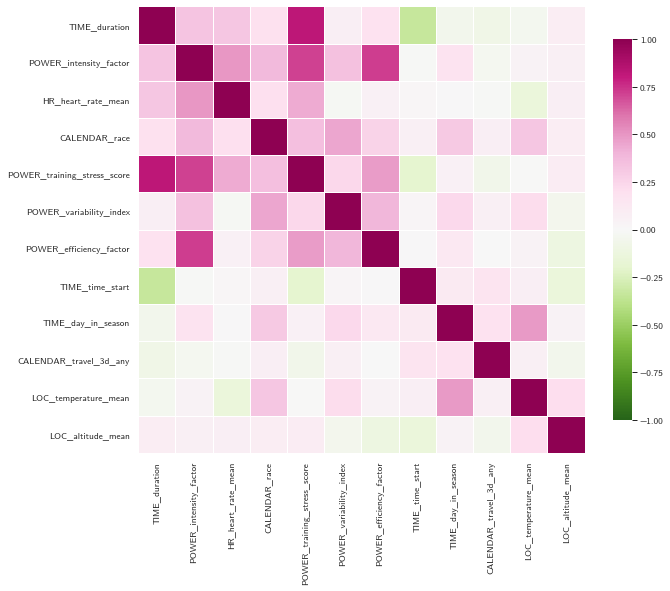

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='PiYG_r',
            linewidths=.5, cbar_kws=dict(shrink=0.7), square=True)
plt.xlabel('') ; plt.ylabel('') ; plt.show()

Perform analysis in R

In [40]:
from rpy2.robjects.packages import importr

from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

base = importr('base')
stats = importr('stats')
lme4 = importr('lme4')

/local/home/evanweenen/.local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [41]:
from itertools import combinations

def get_formula(X, y, interactions=False, random_effects=False):
    
    cols_X = X.columns if type(X) == pd.DataFrame else [X.name]
    groups = list(X.index.names)[0]
    
    # create joint dataframe
    X = X.reset_index()
    y = y.reset_index(drop=True)
    y = y.to_frame() if type(y) == pd.Series else y
    data = pd.concat([X, y], axis=1)
    
    # get formula
    formula_y = y.columns[0] + '~'
    formula_fix = '1+' + '+'.join(cols_X)
    formula_int = ''.join([f'+{col_A}*{col_B}' if interactions else '' for col_A, col_B in combinations(cols_X, 2)])
    if random_effects:
        formula_rnd = f'+(1|{groups})+' + '+'.join([f'({col}|{groups})' for col in cols_X])
    else:
        formula_rnd = f'+(1|{groups})'

    return data, (formula_y, formula_fix, formula_int, formula_rnd)

In [42]:
def GLMM(X, y, family='binomial', fname='', **kwargs):    
    
    data, formula = get_formula(X, y, **kwargs)
    formula = ''.join(formula)

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(data)
        
    model = lme4.glmer(formula, data=r_df, family=family)
    
    base.sink(f'{SAVE_PATH}model_{family}_{fname}.txt')
    print(base.summary(model))
    base.sink()  # returns output to the console

    return model, base.summary(model)

In [43]:
def read_regression_results(filename):
    """
    Read regression results from R to pandas table in python
    """
    with open(filename) as f:
        lines = f.readlines()

    # identify start and end
    start_score = np.where([l.lstrip().startswith('AIC') for l in lines])[0][0]
    start_res = np.where([l.startswith('Scaled residuals') for l in lines])[0][0]
        
    start = np.where([l.startswith('Random effects') for l in lines])[0][0]
    mid = np.where([l.startswith('Fixed effects') for l in lines])[0][0]
    end = np.where([l.startswith(('Signif. codes', 'Correlation of Fixed Effects')) for l in lines])[0][0]

    # read csv
    fe = pd.read_csv(filename, skiprows=mid+1, skipfooter=len(lines)-end+1, 
                     delim_whitespace=True, engine='python')
    re = pd.read_csv(filename, skiprows=start+1, skipfooter=len(lines)-mid+2, 
                     delim_whitespace=True, engine='python')
    fe.columns = ['Feature', 'Estimate', 'Std. Error', 'z value', 'Pr(>|z|)', 'Sign']
    
    score = pd.read_csv(filename, skiprows=start_score, skipfooter=len(lines)-start_score-3, 
                    delim_whitespace=True, engine='python')
    res = pd.read_csv(filename, skiprows=start_res+1, skipfooter=len(lines)-start_res-4, 
                    delim_whitespace=True, engine='python')
    
    return fe, re, score, res

In [44]:
from copy import copy

def combine_regression_results(event, name, family='binomial'):
    # read model results from files
    fe, re, score, res = {}, {}, {}, {}
    for sec in ('exercise', 'recovery', 'sleep'):
        fe[sec], re[sec], score[sec], res[sec] = read_regression_results(SAVE_PATH+f'model_{family}_{event}_{sec}_{name}.txt')
        fe[sec] = fe[sec].set_index('Feature')
    fe = pd.concat(fe)
    re = pd.concat(re)
    score = pd.concat(score, axis=1)
    res = pd.concat(res, axis=1)

    # calculate upper and lower 95% CI boundary
    fe['CI_lower'] = fe['Estimate'] - 1.96*fe['Std. Error']
    fe['CI_upper'] = fe['Estimate'] + 1.96*fe['Std. Error']
    
    # round off
    cols_fe = ['Estimate', 'CI_lower', 'CI_upper', 'Pr(>|z|)']
    fe[cols_fe] = fe[cols_fe].round(2)
    
    # convert format
    cols_fe += ['Sign']
    fe = fe[cols_fe].reset_index().pivot(index='Feature', columns='level_0')
    fe.columns = fe.columns.swaplevel(0,1)
    fe = fe[pd.MultiIndex.from_product([fe.columns.get_level_values(0).unique(), cols_fe])]
    fe.columns.names = [None, None]

    cols_re = ['Variance', 'Std.Dev.']
    re = re.reset_index().pivot(index='Groups', columns=['level_0'], values=cols_re)
    re.columns = re.columns.swaplevel(0,1)
    re = re[pd.MultiIndex.from_product([re.columns.get_level_values(0).unique(), cols_re])]
    re.columns.names = [None, None]
    re = re.round(2)
    
    cols_0 = {**{"(Intercept)": "Intercept"}, **copy(cols_select)}
    fe = fe.sort_index(key = lambda x: x.map({key:k+1 for k, key in enumerate(cols_0.keys())}))
    fe = fe.rename(index=cols_0)
    fe = fe.replace({None:''})
    return fe, re, score, res

In [45]:
from IPython.display import display

def regress(data, x, name, event, family='binomial', show_boxplot=False, show_hist=False):
    print(event.upper())
    print(f"{family}: {event} ~ {'+'.join(x)}")
    if show_hist:
        for col in x:
            sns.kdeplot(data=data, x=col, hue='RIDER', palette=palette_ath) ; plt.show()
    for sec in ('exercise', 'recovery', 'sleep'):
        y = f'GLUCOSE_{event}_{sec}'
        if show_boxplot:
            for col in x:
                fig, ax = plt.subplots(figsize=(8,4))
                sns.boxplot(ax=ax, data=data.reset_index(), x='RIDER', y=col, hue=y)
                plt.show()
        model, summary = GLMM(data[x], data[y], fname=f'{event}_{sec}_{name}', family=family)
    fe, re, score, res = combine_regression_results(event, name, family)
    display(score)
    display(res)
    display(re)
    display(fe)
    return fe, re, score, res

Duration

HYPO
binomial: hypo ~ TIME_duration


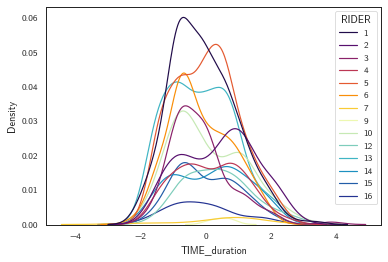

exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1434.4  1450.5 -714.2   1428.4     1608   1537.9  1554.0 -765.9   1531.9   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1732.4  1748.6 -863.2   1726.4     1608

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.3915 -0.5206 -0.3522 -0.1436  7.1049  -1.2633 -0.4806 -0.4065 -0.1896   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.2419 -1.2401 -0.7105 -0.4064  0.9277  4.2804

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      1.25     1.12     1.42     1.19     0.76     0.87

exercise                                 recovery                    \
          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper   
Feature                                                                         
Intercept    -1.67    -2.31    -1.03     0.00  ***    -1.47    -2.15    -0.78   
Duration      0.18     0.05     0.30     0.01   **     0.05    -0.07     0.18   

                           sleep                                  
          Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept     0.00  ***    -1.12    -1.62    -0.62     0.00  ***  
Duration      0.39          0.12     0.01     0.24     0.04    *

HYPER
binomial: hyper ~ TIME_duration





exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2025.0  2041.1 -1009.5   2019.0     1608   1753.9  1770.0 -873.9   1747.9   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1978.5  1994.6 -986.2   1972.5     1608

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.6109 -0.8515  0.5101  0.7655  1.7328  -4.2365 -0.7514  0.4296  0.5748   

            sleep                                 
      Max     Min      1Q  Median     3Q     Max  
0  2.0383 -1.8611 -0.8245 -0.3861  0.971  2.8434

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      0.46     0.68     1.15     1.07     0.96     0.98

exercise                                 recovery                    \
          Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper   
Feature                                                                         
Intercept     0.48     0.09     0.87     0.02    *     1.07     0.46     1.68   
Duration      0.29     0.19     0.40     0.00  ***    -0.20    -0.31    -0.08   

                           sleep                                  
          Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|) Sign  
Feature                                                           
Intercept      0.0  ***    -0.05    -0.60     0.50     0.86       
Duration       0.0  ***    -0.06    -0.17     0.05     0.26

In [46]:
fe, re, score, res = regress(data, x=['TIME_duration'], name='duration', event='hypo', show_hist=True)
fe, re, score, res = regress(data, x=['TIME_duration'], name='duration', event='hyper')

Power

HYPO
binomial: hypo ~ POWER_intensity_factor


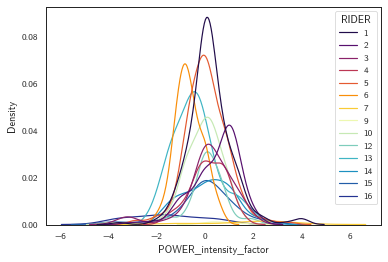

exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1437.9  1454.1 -716.0   1431.9     1608   1538.0  1554.1 -766.0   1532.0   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1733.8  1749.9 -863.9   1727.8     1608

exercise                                recovery                          \
       Min     1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.4389 -0.524 -0.3455 -0.1496  6.7612  -1.2478 -0.4797 -0.4045 -0.1909   

           sleep                                 
     Max     Min     1Q  Median      3Q     Max  
0  5.217 -1.1711 -0.716 -0.4085  0.9202  4.3924

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      1.27     1.13     1.43     1.19     0.77     0.88

exercise                                 recovery           \
                 Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept           -1.66    -2.31    -1.02     0.00  ***    -1.46    -2.14   
Intensity factor    -0.14    -0.29     0.00     0.05    .     0.06    -0.08   

                                           sleep                             \
                 CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                       
Intercept           -0.78     0.00  ***    -1.11    -1.61    -0.61     0.00   
Intensity factor     0.20     0.44          0.11    -0.02     0.24     0.09   

                       
                 Sign  
Feature                
Intercept         ***  
Intensity factor    .

HYPER
binomial: hyper ~ POWER_intensity_factor





exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1984.3  2000.5 -989.2   1978.3     1608   1764.6  1780.8 -879.3   1758.6   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1979.3  1995.4 -986.6   1973.3     1608

exercise                                recovery                          \
       Min      1Q Median      3Q     Max      Min      1Q  Median      3Q   
0  -3.7347 -0.8242  0.482  0.7514  2.7484   -3.675 -0.7666  0.4287  0.5656   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  1.8566 -1.8415 -0.8213 -0.3818  0.9625  2.7647

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      0.44     0.66     1.11     1.06     0.96     0.98

exercise                                 recovery           \
                 Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept            0.52     0.14     0.91     0.01   **     1.05     0.45   
Intensity factor     0.50     0.38     0.62     0.00  ***     0.04    -0.09   

                                           sleep                             \
                 CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                       
Intercept            1.64     0.00  ***    -0.05    -0.60     0.49     0.84   
Intensity factor     0.16     0.58         -0.04    -0.16     0.08     0.50   

                       
                 Sign  
Feature                
Intercept              
Intensity factor

In [47]:
fe, re, score, res = regress(data, x=['POWER_intensity_factor'], name='if', event='hypo', show_hist=True)
fe, re, score, res = regress(data, x=['POWER_intensity_factor'], name='if', event='hyper')

HYPO
binomial: hypo ~ POWER_normalised_power


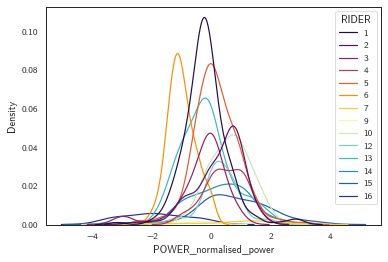

exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1438.6  1454.8 -716.3   1432.6     1608   1537.4  1553.5 -765.7   1531.4   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1734.2  1750.3 -864.1   1728.2     1608

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.4647 -0.5236 -0.3435 -0.1493  6.7716  -1.2778 -0.4798 -0.4045 -0.1908   

            sleep                                 
      Max     Min      1Q Median      3Q     Max  
0  5.2096 -1.1603 -0.7176 -0.409  0.9221  4.3856

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      1.29     1.13     1.38     1.18     0.79     0.89

exercise                                 recovery  \
                       Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                    
Intercept                 -1.66    -2.31    -1.02     0.00  ***    -1.46   
POWER_normalised_power    -0.15    -0.32     0.02     0.08    .     0.09   

                                                          sleep           \
                       CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                    
Intercept                 -2.13    -0.79     0.00  ***    -1.11    -1.62   
POWER_normalised_power    -0.07     0.25     0.27          0.12    -0.03   

                                               
                       CI_upper Pr(>|z|) Sign  
Feature                                        
Intercept                 -0.61     0.00  ***  
POWER_normalised_power     0.26     0.11

HYPER
binomial: hyper ~ POWER_normalised_power





exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1985.8  2002.0 -989.9   1979.8     1608   1764.5  1780.7 -879.3   1758.5   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1979.3  1995.4 -986.6   1973.3     1608

exercise                                recovery                          \
       Min      1Q Median      3Q     Max      Min      1Q  Median      3Q   
0  -4.4144 -0.8216   0.48  0.7535  2.7175   -3.685 -0.7662  0.4313  0.5653   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  1.8643 -1.8473 -0.8217 -0.3818  0.9666  2.7706

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      0.41     0.64     1.12     1.06     0.96     0.98

exercise                                 recovery  \
                       Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                    
Intercept                  0.52     0.15     0.90     0.01   **     1.05   
POWER_normalised_power     0.57     0.43     0.71     0.00  ***     0.04   

                                                          sleep           \
                       CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                    
Intercept                  0.45     1.64     0.00  ***    -0.06    -0.60   
POWER_normalised_power    -0.10     0.19     0.55         -0.05    -0.18   

                                               
                       CI_upper Pr(>|z|) Sign  
Feature                                        
Intercept                  0.49     0.84       
POWER_normalised_power     0.09     0.50

In [48]:
fe, re, score, res = regress(data, x=['POWER_normalised_power'], name='np', event='hypo', show_hist=True)
fe, re, score, res = regress(data, x=['POWER_normalised_power'], name='np', event='hyper')

HYPO
binomial: hypo ~ POWER_power_mean


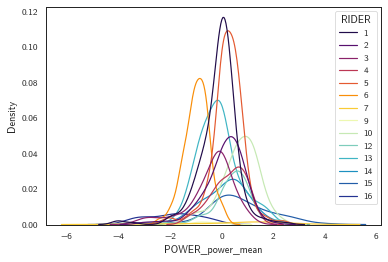

exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1439.3  1455.5 -716.7   1433.3     1608   1536.0  1552.1 -765.0   1530.0   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1733.8  1749.9 -863.9   1727.8     1608

exercise                                recovery                          \
       Min      1Q Median      3Q     Max      Min      1Q  Median      3Q   
0   -1.192 -0.5238 -0.338 -0.1486  6.8489  -1.3335 -0.4838 -0.4054 -0.1903   

            sleep                                 
      Max     Min     1Q  Median      3Q     Max  
0  5.1639 -1.2001 -0.719 -0.4105  0.9313  4.3578

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      1.28     1.13     1.35     1.16     0.79     0.89

exercise                                 recovery           \
                 Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept           -1.65    -2.30    -1.01     0.00  ***    -1.45    -2.12   
POWER_power_mean     0.13    -0.04     0.30     0.13          0.13    -0.03   

                                           sleep                             \
                 CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                       
Intercept           -0.79     0.00  ***    -1.11    -1.62    -0.60     0.00   
POWER_power_mean     0.29     0.11          0.13    -0.02     0.27     0.09   

                       
                 Sign  
Feature                
Intercept         ***  
POWER_power_mean    .

HYPER
binomial: hyper ~ POWER_power_mean





exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2039.6  2055.8 -1016.8   2033.6     1608   1762.2  1778.4 -878.1   1756.2   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1979.6  1995.8 -986.8   1973.6     1608

exercise                                 recovery                         \
       Min      1Q  Median      3Q     Max      Min      1Q Median      3Q   
0  -3.1074 -0.8299  0.5278  0.7727  1.7736  -3.9562 -0.7639   0.42  0.5713   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.0019 -1.8168 -0.8245 -0.3799  0.9632  2.6918

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      0.42     0.65     1.14     1.06     0.95     0.98

exercise                                 recovery           \
                 Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                       
Intercept            0.51     0.13     0.88     0.01   **     1.05     0.44   
POWER_power_mean     0.26     0.13     0.39     0.00  ***    -0.12    -0.27   

                                           sleep                             \
                 CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                       
Intercept            1.65      0.0  ***    -0.06    -0.60     0.49     0.84   
POWER_power_mean     0.03      0.1         -0.02    -0.15     0.12     0.79   

                       
                 Sign  
Feature                
Intercept              
POWER_power_mean

In [49]:
fe, re, score, res = regress(data, x=['POWER_power_mean'], name='power_mean', event='hypo', show_hist=True)
fe, re, score, res = regress(data, x=['POWER_power_mean'], name='power_mean', event='hyper')

HYPO
binomial: hypo ~ POWER_power_sum


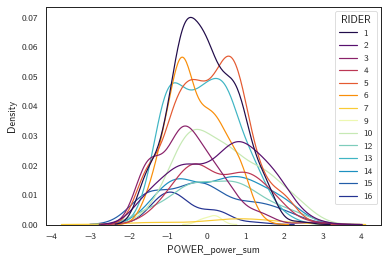

exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1439.9  1456.0 -716.9   1433.9     1608   1538.0  1554.2 -766.0   1532.0   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1732.6  1748.7 -863.3   1726.6     1608

exercise                                recovery                          \
       Min      1Q  Median     3Q     Max      Min      1Q  Median      3Q   
0  -1.2119 -0.5216 -0.3441 -0.149  6.7886  -1.2388 -0.4798 -0.4069 -0.1903   

            sleep                                 
      Max     Min     1Q  Median      3Q     Max  
0  5.3937 -1.2501 -0.713 -0.4049  0.9321  4.2556

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      1.26     1.12     1.42     1.19     0.78     0.88

exercise                                 recovery           \
                Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                      
Intercept          -1.66    -2.30    -1.02     0.00  ***    -1.46    -2.14   
POWER_power_sum     0.10    -0.04     0.23     0.18          0.05    -0.08   

                                          sleep                             \
                CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                      
Intercept          -0.78     0.00  ***    -1.12    -1.63    -0.62     0.00   
POWER_power_sum     0.18     0.45          0.13     0.01     0.25     0.04   

                      
                Sign  
Feature               
Intercept        ***  
POWER_power_sum    *

HYPER
binomial: hyper ~ POWER_power_sum





exercise                                   recovery                          \
       AIC     BIC  logLik deviance df.resid      AIC     BIC logLik deviance   
0   2031.3  2047.4 -1012.6   2025.3     1608   1754.1  1770.3 -874.1   1748.1   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1976.7  1992.8 -985.3   1970.7     1608

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -2.7105 -0.8427  0.5114  0.7699  1.6263    -4.23 -0.7458  0.4291  0.5761   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.0859 -1.9196 -0.8183 -0.3874  0.9599  2.9349

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      0.46     0.68     1.16     1.08     0.97     0.99

exercise                                 recovery           \
                Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                      
Intercept           0.49     0.09     0.88     0.02    *     1.07     0.46   
POWER_power_sum     0.28     0.17     0.40     0.00  ***    -0.21    -0.34   

                                          sleep                             \
                CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                      
Intercept           1.68      0.0  ***    -0.05    -0.60     0.50     0.86   
POWER_power_sum    -0.09      0.0   **    -0.10    -0.22     0.01     0.08   

                      
                Sign  
Feature               
Intercept             
POWER_power_sum    .

In [50]:
fe, re, score, res = regress(data, x=['POWER_power_sum'], name='power_sum', event='hypo', show_hist=True)
fe, re, score, res = regress(data, x=['POWER_power_sum'], name='power_sum', event='hyper')

HYPO
binomial: hypo ~ POWER_variability_index


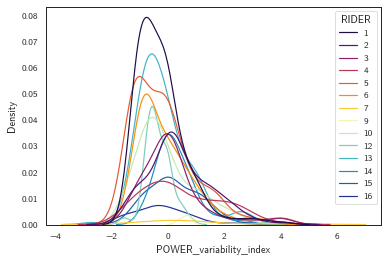

exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1411.4  1427.6 -702.7   1405.4     1608   1538.5  1554.7 -766.3   1532.5   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1736.7  1752.9 -865.4   1730.7     1608

exercise                                 recovery                          \
       Min      1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0  -1.4703 -0.5267 -0.3455 -0.1439  7.1655  -1.1947 -0.4774 -0.4054 -0.1936   

            sleep                                 
      Max     Min     1Q  Median      3Q     Max  
0  5.1398 -1.0763 -0.715 -0.4142  0.9379  4.1833

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      1.29     1.14     1.43      1.2     0.76     0.87

exercise                                 recovery           \
                  Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                        
Intercept            -1.68    -2.32    -1.03      0.0  ***    -1.46    -2.14   
Variability index    -0.40    -0.55    -0.25      0.0  ***    -0.02    -0.14   

                                            sleep                             \
                  CI_upper Pr(>|z|) Sign Estimate CI_lower CI_upper Pr(>|z|)   
Feature                                                                        
Intercept            -0.78     0.00  ***    -1.11    -1.61    -0.61     0.00   
Variability index     0.11     0.78         -0.01    -0.13     0.11     0.87   

                        
                  Sign  
Feature                 
Intercept          ***  
Variability index

HYPER
binomial: hyper ~ POWER_variability_index





ParserError: Expected 6 fields in line 811, saw 7. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.

In [51]:
fe, re, score, res = regress(data, x=['POWER_variability_index'], name='vi', event='hypo', show_hist=True)
fe, re, score, res = regress(data, x=['POWER_variability_index'], name='vi', event='hyper')

In [65]:
filename = SAVE_PATH+f'model_binomial_hyper_{sec}_vi.txt'
with open(filename) as f:
    lines = f.readlines()
        
    # identify start and end
    start_score = np.where([l.lstrip().startswith('AIC') for l in lines])[0][0]
    start_res = np.where([l.startswith('Scaled residuals') for l in lines])[0][0]
        
    start = np.where([l.startswith('Random effects') for l in lines])[0][0]
    mid = np.where([l.startswith('Fixed effects') for l in lines])[0][0]
    end = np.where([l.startswith(('Signif. codes', 'Correlation of Fixed Effects')) for l in lines])[0][0]

"""
    # read csv
    fe = pd.read_csv(filename, skiprows=mid+1, skipfooter=len(lines)-end+1, 
                     delim_whitespace=True, engine='python')
    re = pd.read_csv(filename, skiprows=start+1, skipfooter=len(lines)-mid+2, 
                     delim_whitespace=True, engine='python')
    fe.columns = ['Feature', 'Estimate', 'Std. Error', 'z value', 'Pr(>|z|)', 'Sign']
    
    score = pd.read_csv(filename, skiprows=start_score, skipfooter=len(lines)-start_score-3, 
                    delim_whitespace=True, engine='python')
    res = pd.read_csv(filename, skiprows=start_res+1, skipfooter=len(lines)-start_res-4, 
                    delim_whitespace=True, engine='python')
    
    return fe, re, score, res"""

"\n    # read csv\n    fe = pd.read_csv(filename, skiprows=mid+1, skipfooter=len(lines)-end+1, \n                     delim_whitespace=True, engine='python')\n    re = pd.read_csv(filename, skiprows=start+1, skipfooter=len(lines)-mid+2, \n                     delim_whitespace=True, engine='python')\n    fe.columns = ['Feature', 'Estimate', 'Std. Error', 'z value', 'Pr(>|z|)', 'Sign']\n    \n    score = pd.read_csv(filename, skiprows=start_score, skipfooter=len(lines)-start_score-3, \n                    delim_whitespace=True, engine='python')\n    res = pd.read_csv(filename, skiprows=start_res+1, skipfooter=len(lines)-start_res-4, \n                    delim_whitespace=True, engine='python')\n    \n    return fe, re, score, res"

In [75]:
fe = pd.read_csv(filename, skiprows=mid+1, skipfooter=len(lines)-end+2, delim_whitespace=True, engine='python')
fe

Estimate     Std.  Error      z    value Pr(>|z|)
0  (Intercept)  0.49881   0.19  2.625  0.00866       **

In [55]:
for sec in ('exercise', 'recovery', 'sleep'):
    read_regression_results(SAVE_PATH+f'model_binomial_hyper_{sec}_vi.txt')
    print(sec)

ParserError: Expected 6 fields in line 811, saw 7. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.

HYPO
binomial: hypo ~ POWER_training_stress_score


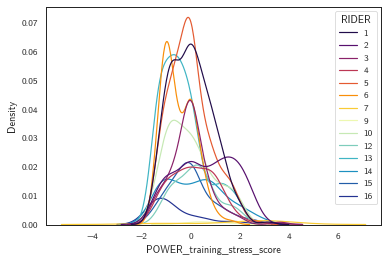

exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1441.5  1457.7 -717.8   1435.5     1608   1537.5  1553.6 -765.7   1531.5   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1733.0  1749.2 -863.5   1727.0     1608

exercise                               recovery                        \
       Min      1Q  Median     3Q    Max      Min      1Q Median     3Q   
0  -1.1105 -0.5178 -0.3327 -0.151  6.646  -1.2711 -0.4816 -0.403 -0.187   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.1933 -1.1934 -0.7122 -0.4061  0.9339  4.3053

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      1.27     1.13     1.43      1.2     0.76     0.87

exercise                                 recovery  \
                      Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                   
Intercept                -1.66    -2.30    -1.01     0.00  ***    -1.47   
Training stress score     0.02    -0.12     0.17     0.73          0.07   

                                                         sleep           \
                      CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                   
Intercept                -2.15    -0.79     0.00  ***    -1.12    -1.62   
Training stress score    -0.06     0.21     0.28          0.12    -0.00   

                                              
                      CI_upper Pr(>|z|) Sign  
Feature                                       
Intercept                -0.62     0.00  ***  
Training stress score     0.25     0.05    .

HYPER
binomial: hyper ~ POWER_training_stress_score





exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   2000.6  2016.7 -997.3   1994.6     1608   1760.3  1776.4 -877.1   1754.3   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1608  1979.3  1995.5 -986.7   1973.3     1608

exercise                                recovery                         \
       Min      1Q  Median      3Q    Max      Min      1Q Median      3Q   
0  -3.0643 -0.8269  0.4806  0.7623  1.796  -4.0816 -0.7622  0.427  0.5745   

            sleep                                 
      Max     Min      1Q  Median     3Q     Max  
0  2.0329 -1.8337 -0.8231 -0.3821  0.963  2.7646

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      0.44     0.66     1.18     1.08     0.96     0.98

exercise                                 recovery  \
                      Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                   
Intercept                 0.49     0.10     0.87     0.01    *     1.07   
Training stress score     0.44     0.32     0.56     0.00  ***    -0.14   

                                                         sleep           \
                      CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                   
Intercept                 0.45     1.68     0.00  ***    -0.05    -0.60   
Training stress score    -0.27    -0.01     0.03    *    -0.04    -0.16   

                                              
                      CI_upper Pr(>|z|) Sign  
Feature                                       
Intercept                 0.50     0.86       
Training stress score     0.08     0.52

In [52]:
fe, re, score, res = regress(data, x=['POWER_training_stress_score'], name='tss', event='hypo', show_hist=True)
fe, re, score, res = regress(data, x=['POWER_training_stress_score'], name='tss', event='hyper')

In [244]:
data

TIME_duration  HR_heart_rate_mean  POWER_intensity_factor  \
RIDER                                                              
1          -0.703021            2.796759                0.061562   
1          -0.645021            1.928133               -0.881411   
1          -0.005848            2.273151                0.062773   
1          -0.725988            1.226992               -0.168369   
1          -0.015969            1.109585                0.053590   
...              ...                 ...                     ...   
16         -0.914586           -1.500632               -0.840375   
16          1.823113            1.705637                0.769894   
16          0.523747            0.244530                0.498398   
16          0.564036            0.665501                0.218984   
16         -0.441824           -2.497433               -1.164035   

       HR_perc_in_hr_zone3  HR_perc_in_hr_zone4  HR_perc_in_hr_zone5  \
RIDER                                                                  
1                 1.409364             4.127114            -0.249960   
1                 3.575643             0.404033            -0.234454   
1                 2.533838             2.362483            -0.249960   
1                 2.366996            -0.629619            -0.249960   
1                 2.356477            -0.629619            -0.249960   
...                    ...                  ...                  ...   
16                0.994317             3.047530             0.247462   
16               -0.682999             0.911736             4.908687   
16               -0.047962             1.806684             4.745598   
16               -0.359651             1.143881             4.908687   
16                1.004880             0.393701            -0.104832   

       POWER_training_stress_score  POWER_fitness  POWER_fatigue  POWER_form  \
RIDER                                                                          
1                        -0.605166      -0.843761      -1.189552    0.972228   
1                        -0.891022      -1.030341      -1.497990    1.257771   
1                        -0.126686      -0.963387      -0.961737    0.491307   
1                        -0.701325      -1.065940      -1.109268    0.613930   
1                        -0.138464      -1.005318      -0.835776    0.250798   
...                            ...            ...            ...         ...   
16                       -1.009137      -1.283112       0.059485   -1.437403   
16                        1.854415      -0.893789       0.951327   -2.420549   
16                        0.533411      -0.752881       0.972037   -2.305068   
16                        0.369586      -0.648752       0.907582   -2.095285   
16                       -0.891250      -0.758176       0.244716   -1.175819   

       ...  LOC_temperature_mean  LOC_altitude_mean  GLUCOSE_hypo_wake  \
RIDER  ...                                                               
1      ...             -1.412435           0.273887                1.0   
1      ...             -1.351121           0.208766                1.0   
1      ...             -1.187983           0.637443                1.0   
1      ...             -1.326070           0.517917                1.0   
1      ...             -1.173284           0.559446                1.0   
...    ...                   ...                ...                ...   
16     ...             -0.655589          -0.670531                1.0   
16     ...             -1.388698           0.176041                1.0   
16     ...             -0.408529           0.010397                1.0   
16     ...             -0.860199           0.007784                1.0   
16     ...             -0.198871          -0.518156                1.0   

       GLUCOSE_hypo_exercise  GLUCOSE_hypo_recovery  GLUCOSE_hypo_sleep  \
RIDER                                                                     
1                        1.0   

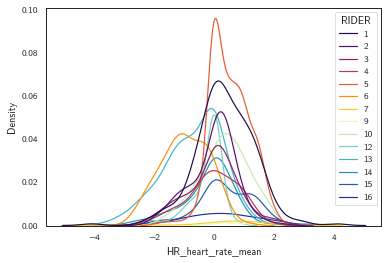

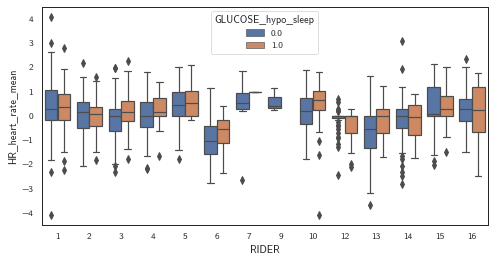

In [46]:
fe, re, score, res = regress(data, x=['TIME_duration'], name='duration', event='hypo', show_hist=True)
fe, re, score, res = regress(data, x=['TIME_duration'], name='duration', event='hyper')

In [47]:
model, summary = GLMM(data['HR_heart_rate_mean'], data['GLUCOSE_hypo_sleep'], fname='hypo_sleep_hr')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + HR_heart_rate_mean + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


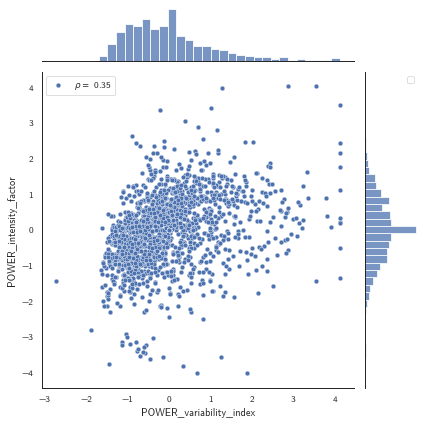

In [132]:
import scipy as sp
sns.jointplot(data=data, x='POWER_variability_index', y='POWER_intensity_factor', 
              label=r"$\rho =$ {:.2f}".format(sp.stats.pearsonr(data['POWER_variability_index'], data['POWER_intensity_factor'])[0]))
plt.legend() ; plt.show()

## FINAL MODELS

HYPO
binomial: hypo ~ TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+CALENDAR_race+POWER_training_stress_score+POWER_variability_index+POWER_efficiency_factor+TIME_time_start+TIME_day_in_season+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean


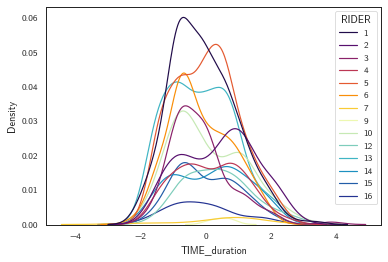

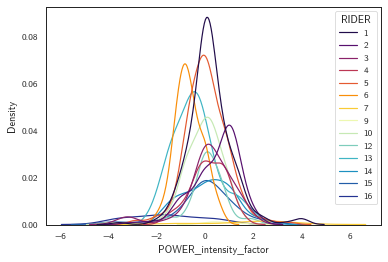

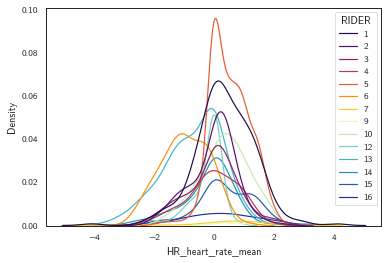

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


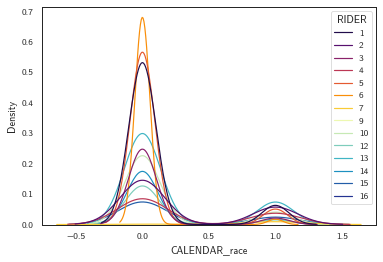

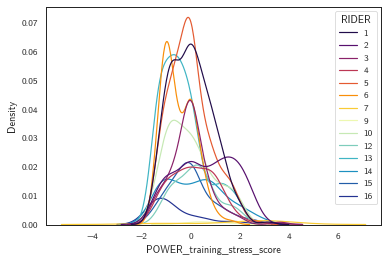

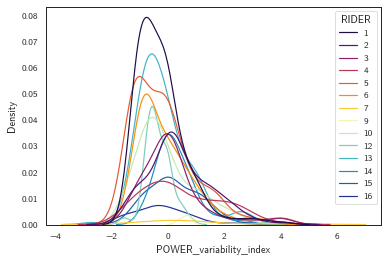

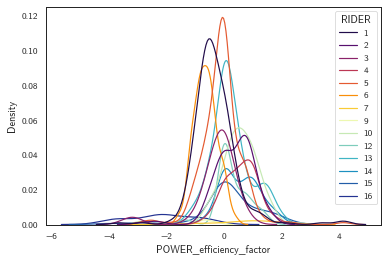

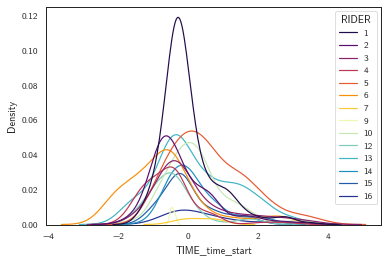

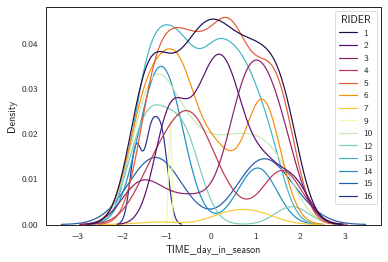

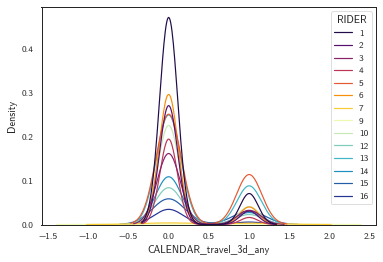

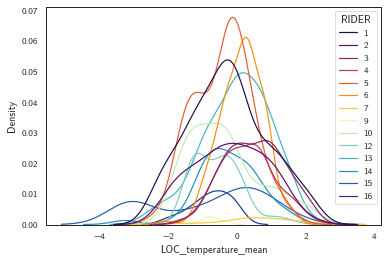

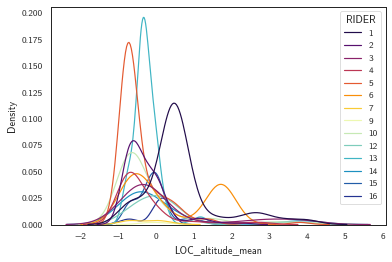

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1354.9  1430.3 -663.4   1326.9     1597   1534.1  1609.5 -753.1   1506.1   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1597  1729.6  1804.9 -850.8   1701.6     1597

exercise                                  recovery                          \
       Min      1Q  Median      3Q      Max      Min      1Q  Median      3Q   
0  -1.9961 -0.4964 -0.2849 -0.1073  12.3634  -1.8137 -0.5056 -0.3802 -0.1728   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  5.5317 -1.3762 -0.6635 -0.3974  0.9045  4.5094

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      1.48     1.22     1.52     1.23     0.72     0.85

exercise                                 recovery  \
                      Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                   
Intercept                -1.56    -2.26    -0.86     0.00  ***    -1.47   
Duration                  0.65     0.26     1.04     0.00   **     0.06   
Intensity factor          0.29    -0.22     0.80     0.27          0.09   
Heart rate               -0.20    -0.47     0.07     0.14         -0.17   
Competitive aspect       -1.62    -2.31    -0.94     0.00  ***    -0.49   
Training stress score    -0.40    -0.94     0.14     0.14          0.09   
Variability index        -0.29    -0.48    -0.10     0.00   **    -0.02   
Efficiency factor        -0.05    -0.50     0.39     0.81          0.10   
Starting time             0.05    -0.11     0.22     0.52          0.04   
Day in season            -0.11    -0.27     0.06     0.20         -0.10   
Travel                   -0.00    -0.39     0.39     1.00          0.19   
Temperature               0.15    -0.03     0.33     0.09    .     0.06   
Altitude                 -0.42    -0.62    -0.23     0.00  ***    -0.21   

                                                         sleep           \
                      CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                   
Intercept                -2.18    -0.75     0.00  ***    -1.06    -1.56   
Duration                 -0.27     0.40     0.71          0.29    -0.01   
Intensity factor         -0.32     0.49     0.67          0.14    -0.22   
Heart rate               -0.39     0.05     0.13          0.07    -0.13   
Competitive aspect       -0.98     0.01     0.05    .    -0.01    -0.46   
Training stress score    -0.37     0.56     0.69         -0.26    -0.67   
Variability index        -0.18     0.13     0.79         -0.02    -0.16   
Efficiency factor        -0.25     0.46     0.57          0.03    -0.31   
Starting time            -0.11     0.19     0.62          0.11    -0.03   
Day in season            -0.26     0.05     0.17          0.21     0.07   
Travel                   -0.15     0.54     0.27         -0.36    -0.69   
Temperature              -0.10     0.23     0.43         -0.27    -0.42   
Altitude                 -0.38    -0.05     0.01    *    -0.03    -0.16   

                                              
                      CI_upper Pr(>|z|) Sign  
Feature                                       
Intercept                -0.56     0.00  ***  
Duration                  0.60     0.06    .  
Intensity factor          0.51     0.44       
Heart rate                0.27     0.51       
Competitive aspect        0.44     0.95       
Training stress score     0.16     0.23       
Variability index         0.13     0.84       
Efficiency factor         0.37     0.88       
Starting time             0.25     0.12       
Day in season             0.36     0.00   **  
Travel                   -0.02     0.04    *  
Temperature              -0.12     0.00  ***  
Altitude                  0.11     0.72

HYPER
binomial: hyper ~ TIME_duration+POWER_intensity_factor+HR_heart_rate_mean+CALENDAR_race+POWER_training_stress_score+POWER_variability_index+POWER_efficiency_factor+TIME_time_start+TIME_day_in_season+CALENDAR_travel_3d_any+LOC_temperature_mean+LOC_altitude_mean


R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




exercise                                  recovery                          \
       AIC     BIC logLik deviance df.resid      AIC     BIC logLik deviance   
0   1912.2  1987.6 -942.1   1884.2     1597   1688.2  1763.6 -830.1   1660.2   

             sleep                                   
  df.resid     AIC     BIC logLik deviance df.resid  
0     1597  1990.9  2066.3 -981.5   1962.9     1597

exercise                                recovery                          \
       Min     1Q  Median      3Q     Max      Min      1Q  Median      3Q   
0   -3.877 -0.804  0.3549  0.7302  2.6857   -5.987 -0.6615  0.3667  0.5921   

            sleep                                  
      Max     Min      1Q  Median      3Q     Max  
0  2.6171 -2.0958 -0.8014 -0.3908  0.9368  2.9959

exercise          recovery             sleep         
       Variance Std.Dev. Variance Std.Dev. Variance Std.Dev.
Groups                                                      
RIDER      0.44     0.66     1.23     1.11     0.92     0.96

exercise                                 recovery  \
                      Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                   
Intercept                 0.43     0.03     0.83     0.04    *     1.02   
Duration                  0.41     0.12     0.70     0.01   **     0.00   
Intensity factor          0.23    -0.13     0.59     0.21          0.29   
Heart rate                0.28     0.08     0.47     0.01   **    -0.11   
Competitive aspect        0.58     0.12     1.05     0.01    *     1.10   
Training stress score    -0.38    -0.78     0.03     0.07    .    -0.35   
Variability index         0.34     0.20     0.48     0.00  ***     0.24   
Efficiency factor         0.11    -0.21     0.44     0.50         -0.33   
Starting time             0.09    -0.03     0.22     0.15          0.06   
Day in season            -0.01    -0.14     0.13     0.92          0.05   
Travel                    0.29    -0.01     0.58     0.06    .     0.02   
Temperature               0.20     0.06     0.34     0.01   **     0.23   
Altitude                  0.02    -0.12     0.15     0.78         -0.08   

                                                         sleep           \
                      CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                   
Intercept                 0.39     1.66     0.00   **    -0.11    -0.66   
Duration                 -0.30     0.31     0.98         -0.25    -0.53   
Intensity factor         -0.11     0.68     0.15         -0.25    -0.59   
Heart rate               -0.32     0.11     0.33          0.11    -0.08   
Competitive aspect        0.58     1.62     0.00  ***     0.19    -0.22   
Training stress score    -0.79     0.08     0.11          0.28    -0.10   
Variability index         0.08     0.40     0.00   **    -0.07    -0.20   
Efficiency factor        -0.69     0.03     0.07    .     0.10    -0.21   
Starting time            -0.08     0.20     0.42         -0.02    -0.15   
Day in season            -0.09     0.20     0.46         -0.04    -0.17   
Travel                   -0.31     0.35     0.89          0.16    -0.13   
Temperature               0.07     0.38     0.00   **     0.11    -0.02   
Altitude                 -0.23     0.07     0.30         -0.01    -0.13   

                                              
                      CI_upper Pr(>|z|) Sign  
Feature                                       
Intercept                 0.44     0.69       
Duration                  0.02     0.07    .  
Intensity factor          0.09     0.14       
Heart rate                0.29     0.25       
Competitive aspect        0.60     0.36       
Training stress score     0.66     0.15       
Variability index         0.06     0.28       
Efficiency factor         0.41     0.53       
Starting time             0.10     0.74       
Day in season             0.09     0.56       
Travel                    0.45     0.28       
Temperature               0.25     0.10       
Altitude                  0.12     0.92

In [236]:
fe, re, score, res = regress(data, x=cols_select.keys(), name='all2', event='hypo', show_hist=True)
fe, re, score, res = regress(data, x=cols_select.keys(), name='all2', event='hyper')

### Hypo

Hypo exercise

In [59]:
model, summary = GLMM(data[cols_select.keys()], data['GLUCOSE_hypo_exercise'], fname='hypo_exercise_all')
print(summary)

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it


R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it





Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_exercise ~ 1 + TIME_duration + POWER_intensity_factor +  
    HR_heart_rate_mean + CALENDAR_race + POWER_training_stress_score +  
    POWER_variability_index + POWER_efficiency_factor + TIME_time_start +  
    TIME_day_in_season + CALENDAR_travel_3d_any + LOC_temperature_mean +  
    LOC_altitude_mean + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L

Hypo recovery

In [60]:
model, summary = GLMM(data[cols_select.keys()], data['GLUCOSE_hypo_recovery'], fname='hypo_recovery_all')
print(summary)

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it


R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it





Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_recovery ~ 1 + TIME_duration + POWER_intensity_factor +  
    HR_heart_rate_mean + CALENDAR_race + POWER_training_stress_score +  
    POWER_variability_index + POWER_efficiency_factor + TIME_time_start +  
    TIME_day_in_season + CALENDAR_travel_3d_any + LOC_temperature_mean +  
    LOC_altitude_mean + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L

Hypo sleep

In [61]:
model, summary = GLMM(data[cols_select.keys()], data['GLUCOSE_hypo_sleep'], fname='hypo_sleep_all')
print(summary)

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it


R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it





Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + TIME_duration + POWER_intensity_factor +  
    HR_heart_rate_mean + CALENDAR_race + POWER_training_stress_score +  
    POWER_variability_index + POWER_efficiency_factor + TIME_time_start +  
    TIME_day_in_season + CALENDAR_travel_3d_any + LOC_temperature_mean +  
    LOC_altitude_mean + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1

### Hyper

Hyper exercise

In [62]:
model, summary = GLMM(data[cols_select.keys()], data['GLUCOSE_hyper_exercise'], fname='hyper_exercise_all')
print(summary)

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it


R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it





Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hyper_exercise ~ 1 + TIME_duration + POWER_intensity_factor +  
    HR_heart_rate_mean + CALENDAR_race + POWER_training_stress_score +  
    POWER_variability_index + POWER_efficiency_factor + TIME_time_start +  
    TIME_day_in_season + CALENDAR_travel_3d_any + LOC_temperature_mean +  
    LOC_altitude_mean + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1

Hyper recovery

In [63]:
model, summary = GLMM(data[cols_select.keys()], data['GLUCOSE_hyper_recovery'], fname='hyper_recovery_all')
print(summary)

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it


R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it





Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hyper_recovery ~ 1 + TIME_duration + POWER_intensity_factor +  
    HR_heart_rate_mean + CALENDAR_race + POWER_training_stress_score +  
    POWER_variability_index + POWER_efficiency_factor + TIME_time_start +  
    TIME_day_in_season + CALENDAR_travel_3d_any + LOC_temperature_mean +  
    LOC_altitude_mean + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1

Hyper sleep

In [64]:
model, summary = GLMM(data[cols_select.keys()], data['GLUCOSE_hyper_sleep'], fname='hyper_sleep_all')
print(summary)

R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it


R[write to console]: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it





Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hyper_sleep ~ 1 + TIME_duration + POWER_intensity_factor +  
    HR_heart_rate_mean + CALENDAR_race + POWER_training_stress_score +  
    POWER_variability_index + POWER_efficiency_factor + TIME_time_start +  
    TIME_day_in_season + CALENDAR_travel_3d_any + LOC_temperature_mean +  
    LOC_altitude_mean + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 

## Process model results

In [127]:
fe_hypo, re_hypo = combine_regression_results('hypo')
with open(SAVE_PATH+"hypo.tex", 'w') as file:
	file.write(fe_hypo.to_latex(column_format='c', escape=False))
	file.write(re_hypo.to_latex(column_format='c', escape=False))
fe_hypo

exercise                                 recovery  \
                      Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                   
Intercept                -1.56    -2.26    -0.86     0.00  ***    -1.47   
Duration                  0.65     0.26     1.04     0.00   **     0.06   
Intensity factor          0.29    -0.22     0.80     0.27          0.09   
Heart rate               -0.20    -0.47     0.07     0.14         -0.17   
Competitive aspect       -1.62    -2.31    -0.94     0.00  ***    -0.49   
Training stress score    -0.40    -0.94     0.14     0.14          0.09   
Variability index        -0.29    -0.48    -0.10     0.00   **    -0.02   
Efficiency factor        -0.05    -0.50     0.39     0.81          0.10   
Starting time             0.05    -0.11     0.22     0.52          0.04   
Day in season            -0.11    -0.27     0.06     0.20         -0.10   
Travel                   -0.00    -0.39     0.39     1.00          0.19   
Temperature               0.15    -0.03     0.33     0.09    .     0.06   
Altitude                 -0.42    -0.62    -0.23     0.00  ***    -0.21   

                                                         sleep           \
                      CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                   
Intercept                -2.18    -0.75     0.00  ***    -1.06    -1.56   
Duration                 -0.27     0.40     0.71          0.29    -0.01   
Intensity factor         -0.32     0.49     0.67          0.14    -0.22   
Heart rate               -0.39     0.05     0.13          0.07    -0.13   
Competitive aspect       -0.98     0.01     0.05    .    -0.01    -0.46   
Training stress score    -0.37     0.56     0.69         -0.26    -0.67   
Variability index        -0.18     0.13     0.79         -0.02    -0.16   
Efficiency factor        -0.25     0.46     0.57          0.03    -0.31   
Starting time            -0.11     0.19     0.62          0.11    -0.03   
Day in season            -0.26     0.05     0.17          0.21     0.07   
Travel                   -0.15     0.54     0.27         -0.36    -0.69   
Temperature              -0.10     0.23     0.43         -0.27    -0.42   
Altitude                 -0.38    -0.05     0.01    *    -0.03    -0.16   

                                              
                      CI_upper Pr(>|z|) Sign  
Feature                                       
Intercept                -0.56     0.00  ***  
Duration                  0.60     0.06    .  
Intensity factor          0.51     0.44       
Heart rate                0.27     0.51       
Competitive aspect        0.44     0.95       
Training stress score     0.16     0.23       
Variability index         0.13     0.84       
Efficiency factor         0.37     0.88       
Starting time             0.25     0.12       
Day in season             0.36     0.00   **  
Travel                   -0.02     0.04    *  
Temperature              -0.12     0.00  ***  
Altitude                  0.11     0.72

In [128]:
fe_hyper, re_hyper = combine_regression_results('hyper')
with open(SAVE_PATH+"hyper.tex", 'w') as file:
	file.write(fe_hyper.to_latex(column_format='c', escape=False))
	file.write(re_hyper.to_latex(column_format='c', escape=False))
fe_hyper

exercise                                 recovery  \
                      Estimate CI_lower CI_upper Pr(>|z|) Sign Estimate   
Feature                                                                   
Intercept                 0.43     0.03     0.83     0.04    *     1.02   
Duration                  0.41     0.12     0.70     0.01   **     0.00   
Intensity factor          0.23    -0.13     0.59     0.21          0.29   
Heart rate                0.28     0.08     0.47     0.01   **    -0.11   
Competitive aspect        0.58     0.12     1.05     0.01    *     1.10   
Training stress score    -0.38    -0.78     0.03     0.07    .    -0.35   
Variability index         0.34     0.20     0.48     0.00  ***     0.24   
Efficiency factor         0.11    -0.21     0.44     0.50         -0.33   
Starting time             0.09    -0.03     0.22     0.15          0.06   
Day in season            -0.01    -0.14     0.13     0.92          0.05   
Travel                    0.29    -0.01     0.58     0.06    .     0.02   
Temperature               0.20     0.06     0.34     0.01   **     0.23   
Altitude                  0.02    -0.12     0.15     0.78         -0.08   

                                                         sleep           \
                      CI_lower CI_upper Pr(>|z|) Sign Estimate CI_lower   
Feature                                                                   
Intercept                 0.39     1.66     0.00   **    -0.11    -0.66   
Duration                 -0.30     0.31     0.98         -0.25    -0.53   
Intensity factor         -0.11     0.68     0.15         -0.25    -0.59   
Heart rate               -0.32     0.11     0.33          0.11    -0.08   
Competitive aspect        0.58     1.62     0.00  ***     0.19    -0.22   
Training stress score    -0.79     0.08     0.11          0.28    -0.10   
Variability index         0.08     0.40     0.00   **    -0.07    -0.20   
Efficiency factor        -0.69     0.03     0.07    .     0.10    -0.21   
Starting time            -0.08     0.20     0.42         -0.02    -0.15   
Day in season            -0.09     0.20     0.46         -0.04    -0.17   
Travel                   -0.31     0.35     0.89          0.16    -0.13   
Temperature               0.07     0.38     0.00   **     0.11    -0.02   
Altitude                 -0.23     0.07     0.30         -0.01    -0.13   

                                              
                      CI_upper Pr(>|z|) Sign  
Feature                                       
Intercept                 0.44     0.69       
Duration                  0.02     0.07    .  
Intensity factor          0.09     0.14       
Heart rate                0.29     0.25       
Competitive aspect        0.60     0.36       
Training stress score     0.66     0.15       
Variability index         0.06     0.28       
Efficiency factor         0.41     0.53       
Starting time             0.10     0.74       
Day in season             0.09     0.56       
Travel                    0.45     0.28       
Temperature               0.25     0.10       
Altitude                  0.12     0.92

## HYPO SLEEP

### Simple model

In [41]:
model, summary = GLMM(X[['HR_heart_rate_mean', 'TIME_duration', 'POWER_intensity_factor']], 
                      y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_duration_hr_if')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + HR_heart_rate_mean + TIME_duration +  
    POWER_intensity_factor + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L

### First-order variables of interest (individual models)

Duration

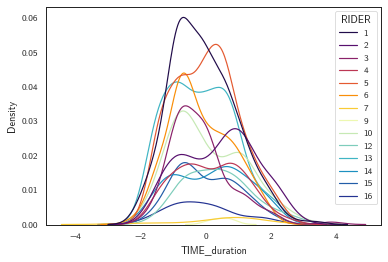

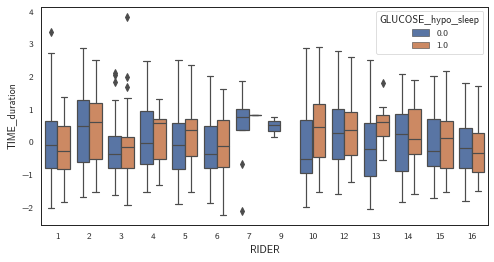

In [42]:
plot_feature(data, x='TIME_duration', y='GLUCOSE_hypo_sleep')

In [43]:
model, summary = GLMM(X['TIME_duration'], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_duration')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + TIME_duration + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 

Intensity factor

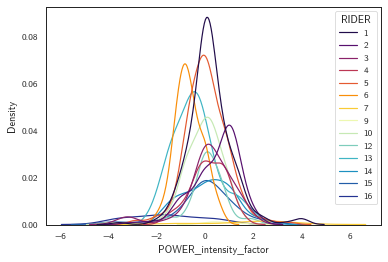

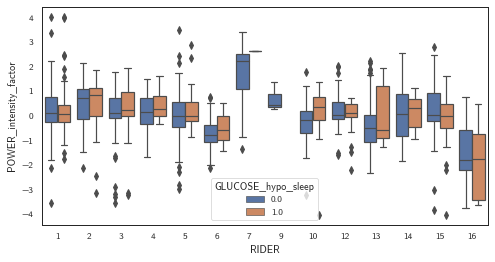

In [44]:
plot_feature(data, x='POWER_intensity_factor', y='GLUCOSE_hypo_sleep')

In [45]:
model, summary = GLMM(X['POWER_intensity_factor'], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_if')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + POWER_intensity_factor + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L,

Heart rate

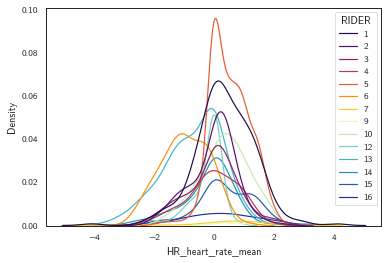

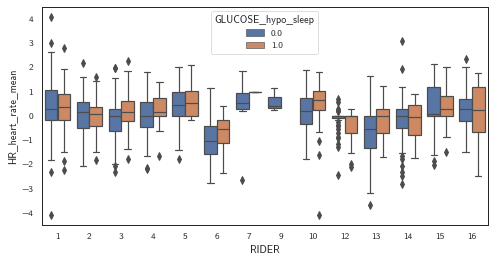

In [46]:
plot_feature(data, x='HR_heart_rate_mean', y='GLUCOSE_hypo_sleep')

In [47]:
model, summary = GLMM(X['HR_heart_rate_mean'], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_hr')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + HR_heart_rate_mean + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L,

In [48]:
model, summary = GLMM(X[['HR_heart_rate_mean', 'TIME_duration']], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_duration_hr')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + HR_heart_rate_mean + TIME_duration +  
    (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,

In [49]:
model, summary = GLMM(X[['POWER_intensity_factor', 'TIME_duration']], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_duration_if')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + POWER_intensity_factor + TIME_duration +  
    (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,

In [50]:
model, summary = GLMM(X[['POWER_intensity_factor', 'TIME_duration']], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_duration*if', interactions=True, )
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + POWER_intensity_factor + TIME_duration +  
    POWER_intensity_factor * TIME_duration + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L

In [51]:
model, summary = GLMM(X[['POWER_variability_index']], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_vi')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + POWER_variability_index + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L

In [52]:
model, summary = GLMM(X[['POWER_efficiency_factor']], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_ef')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + POWER_efficiency_factor + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L

In [53]:
model, summary = GLMM(X[['CALENDAR_race']], y, fname='hypo_sleep_race')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_wake ~ 1 + CALENDAR_race + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1

In [54]:
model, summary = GLMM(X[['CALENDAR_travel_3d_any']], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_travel')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + CALENDAR_travel_3d_any + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L,

### Add secondary order variables

In [55]:
model, summary = GLMM(X[['TIME_duration', 'POWER_intensity_factor', 'CALENDAR_race']], y['GLUCOSE_hypo_sleep'], fname='hypo_sleep_duration_if_race_travel')
print(summary)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: GLUCOSE_hypo_sleep ~ 1 + TIME_duration + POWER_intensity_factor +  
    CALENDAR_race + (1 | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,

In [ ]:
# alternative: use this code to test for distributions
# see: https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ['gamma', 'beta', "norm", 'rayleigh', "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]
# also: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python?lq=1

In [ ]:
# add info
# discretize some variables? 
# - age?


In [ ]:
# add weekday effects
# add quarter of year effects

In [ ]:
# patient ID = random effects
# Note: we do not take athlete-specific effects as they will explain only the average glycemia

In [ ]:
# TODO: pool different times of day

In [ ]:
# TODO: what is target variable????

In [34]:
data

TIME_duration  TIME_time_start  TIME_time_end  \
RIDER day                                                  
1     0        -0.703021        -0.505246      -1.130409   
      1        -0.645021        -0.573752      -1.082219   
      2        -0.005848        -0.289975       0.083818   
      3        -0.725988        -0.378447      -1.018970   
      4        -0.015969         0.184862      -0.017135   
...                  ...              ...            ...   
16    64        1.823113        -0.414708       0.540171   
      65        0.523747        -0.315449      -0.206101   
      66        0.564036        -0.501345      -0.362272   
      67       -0.441824        -0.152389       1.283990   
      68        0.437720        -0.437773      -0.248156   

           CALENDAR_travel_7d_any  CALENDAR_travel_3d_any  CALENDAR_travel  \
RIDER day                                                                    
1     0                       0.0                     0.0              0.0   
      1                       0.0                     0.0              0.0   
      2                       0.0                     0.0              0.0   
      3                       0.0                     0.0              0.0   
      4                       0.0                     0.0              0.0   
...                           ...                     ...              ...   
16    64                      0.0                     0.0              0.0   
      65                      0.0                     0.0              0.0   
      66                      0.0                     0.0              0.0   
      67                      0.0                     0.0              0.0   
      68                      0.0                     0.0              0.0   

           CALENDAR_race  CALENDAR_country_carbs  HR_perc_in_hr_zone1  \
RIDER day                                                               
1     0              0.0                0.021392            -0.967167   
      1              0.0                0.021392            -0.932004   
      2              0.0                0.021392            -0.872389   
      3              0.0                0.021392            -0.842394   
      4              0.0                0.021392            -0.714545   
...                  ...                     ...                  ...   
16    64             0.0               -1.080729            -0.968366   
      65             0.0               -1.080729            -0.961088   
      66             0.0               -1.080729            -0.966410   
      67             0.0               -1.080729            -0.173727   
      68             0.0               -1.080729            -0.947189   

           HR_perc_in_hr_zone2  ...  GLUCOSE_AUC_12h  GLUCOSE_hypo_12h  \
RIDER day                       ...                                      
1     0              -1.267723  ...     1.209902e-16               1.0   
      1              -0.859027  ...    -1.300590e+00               1.0   
      2              -1.006465  ...    -9.398285e-01               1.0   
      3               0.214244  ...    -7.775860e-01               1.0   
      4               0.111263  ...     1.209902e-16               1.0   
...                        ...  ...              ...               ...   
16    64             -1.500638  ...     1.209902e-16               0.0   
      65             -1.343606  ...    -3.480940e-02               1.0   
      66             -1.451753  ...    -9.578941e-02               1.0   
      67              0.032292  ...     3.039932e-01               1.0   
      68             -1.218061  ...     3.284000e-01               0.0   

           GLUCOSE_hyper_12h  GLUCOSE_AUC_1d  GLUCOSE_hypo_1d  \
RIDER day                                                       
1     0                  1.0   -1.230732e-16              1.0   
      1                  1.0   -1.230732e-16              1.0   
      2                  1.0   -1.230732e-

In [237]:
from sklearn.model_selection import LeaveOneGroupOut #TODO
from sklearn.utils import shuffle

In [14]:
info = pd.read_csv(DATA_PATH+'./info.csv', index_col=0)
info.set_index('RIDER', inplace=True)
info

age  diabetes_duration  height     weight     bf(%)  HbA1c  \
RIDER                                                                
1      22.0               11.0   174.0  60.500000  9.066667    6.7   
2      30.0               14.0   178.0  71.633333  8.833333    6.6   
3      26.0                7.0   171.0  66.733333  6.566667    6.8   
4      19.0                7.0   178.0  78.666667  9.433333    7.8   
5      25.0                6.0   183.0  69.633333  7.700000    6.5   
6      20.0                9.0   169.0  56.700000  4.950000    6.4   
10     27.0               17.0   185.0  75.466667  7.700000    7.3   
12     30.0                8.0   178.0  64.000000  5.600000    6.0   
13     34.0                1.0   179.0  60.333333  4.866667    6.3   
14     27.0               17.0   187.0  75.166667  9.333333    7.1   
15     25.0               15.0   179.0  73.766667  7.200000    6.4   

              FTP        LTHR       HRmax     VO2max  
RIDER                                                 
1      307.000000  176.333333  192.333333  68.888889  
2      326.000000  168.666667  181.666667  66.915285  
3      298.000000  171.000000  180.000000  66.666164  
4      356.000000  170.333333  187.333333  67.333333  
5      341.000000  179.666667  192.666667  72.857143  
6      298.500000  173.000000  184.500000  70.781588  
10     377.333333  177.000000  194.333333  73.982571  
12     347.000000  158.333333  178.666667  75.937500  
13     345.666667  173.000000  182.333333  76.666667  
14     348.000000  169.000000  189.500000  66.500000  
15     389.000000  185.000000  198.000000  66.000000

In [27]:
percinlevel = {i:get_percinlevel(df[df.RIDER == i]) for i in ATHLETES}
percinlevel = pd.DataFrame(percinlevel).T
percinlevel['hypo'] = percinlevel['hypo L2'] + percinlevel['hypo L1']
percinlevel['hyper'] = percinlevel['hyper L1'] + percinlevel['hyper L2']
percinlevel

hypo L2   hypo L1     target   hyper L1   hyper L2       hypo      hyper
1   1.209455  6.730493  64.032547  19.491675   8.535830   7.939947  28.027506
2   3.319630  8.091153  66.078939  14.069814   8.224224  11.410783  22.294038
3   1.387432  4.821754  67.102023  20.653035   6.035756   6.209185  26.688791
4   1.772771  3.610159  57.773782  26.127999  10.715289   5.382930  36.843288
5   0.219195  1.275101  83.175026  13.625436   1.596823   1.494296  15.222259
6   0.450731  2.496993  86.588687   9.486084   0.966444   2.947724  10.452528
10  7.973185  6.257463  47.707133  20.995077  17.065047  14.230648  38.060124
12  2.273402  9.284984  83.716633   4.368628   0.326657  11.558386   4.695285
13  0.018693  0.447523  93.712683   5.647369   0.169333   0.466216   5.816702
14  0.309965  1.706257  62.468134  23.988992  11.309386   2.016222  35.298378
15  2.384216  5.185671  71.842403  16.743160   3.844549   7.569887  20.587709

In [28]:
diab = pd.concat([info, percinlevel], axis=1)
diab

age  diabetes_duration  height     weight     bf(%)  HbA1c         FTP  \
1   22.0               11.0   174.0  60.500000  9.066667    6.7  307.000000   
2   30.0               14.0   178.0  71.633333  8.833333    6.6  326.000000   
3   26.0                7.0   171.0  66.733333  6.566667    6.8  298.000000   
4   19.0                7.0   178.0  78.666667  9.433333    7.8  356.000000   
5   25.0                6.0   183.0  69.633333  7.700000    6.5  341.000000   
6   20.0                9.0   169.0  56.700000  4.950000    6.4  298.500000   
10  27.0               17.0   185.0  75.466667  7.700000    7.3  377.333333   
12  30.0                8.0   178.0  64.000000  5.600000    6.0  347.000000   
13  34.0                1.0   179.0  60.333333  4.866667    6.3  345.666667   
14  27.0               17.0   187.0  75.166667  9.333333    7.1  348.000000   
15  25.0               15.0   179.0  73.766667  7.200000    6.4  389.000000   

          LTHR       HRmax     VO2max   hypo L2   hypo L1     target  \
1   176.333333  192.333333  68.888889  1.209455  6.730493  64.032547   
2   168.666667  181.666667  66.915285  3.319630  8.091153  66.078939   
3   171.000000  180.000000  66.666164  1.387432  4.821754  67.102023   
4   170.333333  187.333333  67.333333  1.772771  3.610159  57.773782   
5   179.666667  192.666667  72.857143  0.219195  1.275101  83.175026   
6   173.000000  184.500000  70.781588  0.450731  2.496993  86.588687   
10  177.000000  194.333333  73.982571  7.973185  6.257463  47.707133   
12  158.333333  178.666667  75.937500  2.273402  9.284984  83.716633   
13  173.000000  182.333333  76.666667  0.018693  0.447523  93.712683   
14  169.000000  189.500000  66.500000  0.309965  1.706257  62.468134   
15  185.000000  198.000000  66.000000  2.384216  5.185671  71.842403   

     hyper L1   hyper L2       hypo      hyper  
1   19.491675   8.535830   7.939947  28.027506  
2   14.069814   8.224224  11.410783  22.294038  
3   20.653035   6.035756   6.209185  26.688791  
4   26.127999  10.715289   5.382930  36.843288  
5   13.625436   1.596823   1.494296  15.222259  
6    9.486084   0.966444   2.947724  10.452528  
10  20.995077  17.065047  14.230648  38.060124  
12   4.368628   0.326657  11.558386   4.695285  
13   5.647369   0.169333   0.466216   5.816702  
14  23.988992  11.309386   2.016222  35.298378  
15  16.743160   3.844549   7.569887  20.587709

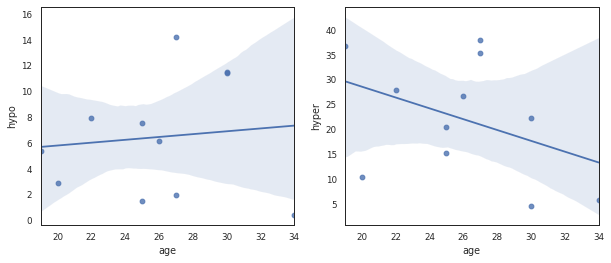

In [34]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.regplot(x='age', y='hypo', data=diab, ax=axs[0])
sns.regplot(x='age', y='hyper', data=diab, ax=axs[1])
plt.show()

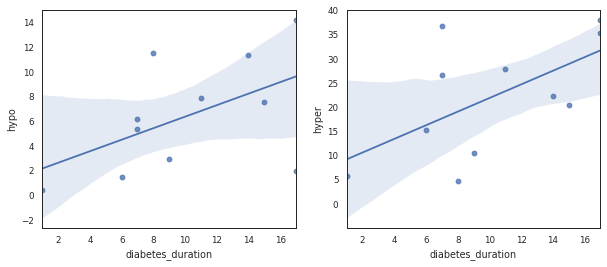

In [37]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.regplot(x='diabetes_duration', y='hypo', data=diab, ax=axs[0])
sns.regplot(x='diabetes_duration', y='hyper', data=diab, ax=axs[1])
plt.show()

In [39]:
import statsmodels.api as sm

diab = sm.add_constant(diab)

model = sm.OLS(diab['hypo'], diab[info.columns])
res = model.fit()
print(res.summary())

model = sm.OLS(diab['hyper'], diab[info.columns])
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   hypo   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.858
Method:                 Least Squares   F-statistic:                              7.657
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                       0.275
Time:                        21:19:31   Log-Likelihood:                         -14.273
No. Observations:                  11   AIC:                                      48.55
Df Residuals:                       1   BIC:                                      52.53
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/local/home/evanweenen/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/local/home/evanweenen/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
